# Data Visualization and Exploratory Analysis Notebook

## Introduction

The overall goal of this project is to see if I can predict both the annual and monthly sales price per bushel of grain corn (which is what people eat, as opposed to silage corn, which is what livestock eats). The annual predictions are useful for planning for the next year, whereas monthly projections help fine tune plans as the year progresses.

All of the data for this project was cleaned in the `Data Scrubbing` notebook. While that notebook was focused primarily on combining and checking the data, the current notebook will primarily be used for visualizing the data and examining its relevance to the target feature, namely the `PRICE RECEIVED, MEASURED IN $ / BU`.

## Plan of Attack

1. Import Analysis Packages
2. Import the annual and monthly scrubbed data
    - Confirm the imports were successful
    - Determine the shapes of the dataframes
    - Provide data dictionaries for the features
3. Visualize and describe the distributions of the different features
    - Plot the feature against the target value and look for trends 
4. Check for multicolinearity of the features 
5. Conclusions

## Import Analysis Packages

I will now setup my notebook with the tools I will need for importing and visualizing the data.

In [1]:
# Import tools and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from scipy import stats
from scipy.stats import linregress
from plotly.subplots import make_subplots
from statsmodels.api import tsa
from statsmodels.graphics.tsaplots import month_plot
from datetime import datetime
from copy import copy

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

## Import the annual and monthly scrubbed data

Here I will import the annual and monthly data that was previously scrubbed. I will then take a quick look at the dataframes created to make sure they look correct. The pandas `read_csv` function does not automatically format datetime features. So, I will infer datetime format and confirm that the formatting was done correctly.

In [2]:
# Import the dataframes
annual_df = pd.read_csv(
    './DataFrames/scrubbed_df_annual.csv',
    index_col=0
)
monthly_df = pd.read_csv(
    './DataFrames/scrubbed_df_monthly.csv', 
    index_col=0, 
    infer_datetime_format=True
)

# Make sure the index of the monly_df is still datetime (as the 'read_csv' function is not so good at this)
monthly_df.index = pd.to_datetime(monthly_df.index)

# Check that the dataframes look the way they are suppoed to
display(annual_df, monthly_df)

# Confirm the monthly_df index was changed to datetime
print(monthly_df.index.dtype)

ACRES HARVESTED  PRODUCTION, MEASURED IN BU  \
Year                                                
1950       72398000.0                2.764071e+09   
1951       71191000.0                2.628937e+09   
1952       71353000.0                2.980793e+09   
1953       70738000.0                2.881801e+09   
1954       68668000.0                2.707913e+09   
...               ...                         ...   
2016       86748000.0                1.514804e+10   
2017       83735781.0                1.469141e+10   
2018       81276000.0                1.434037e+10   
2019       81337000.0                1.361993e+10   
2020       82313000.0                1.411145e+10   

      PRICE RECEIVED, MEASURED IN $ / BU  PRODUCTION, MEASURED IN $  \
Year                                                                  
1950                                1.52               4.222366e+09   
1951                                1.66               4.364659e+09   
1952                                1.52               4.557031e+09   
1953                                1.48               4.291366e+09   
1954                                1.43               3.872433e+09   
...                                  ...                        ...   
2016                                3.36               5.130430e+10   
2017                                3.36               4.956785e+10   
2018                                3.61               5.210240e+10   
2019                                3.56               4.894062e+10   
2020                                4.53               6.103900e+10   

      YIELD, MEASURED IN BU / ACRE  Cooling Degree Days  Heating Degree Days  \
Year                                                                           
1950                          38.2                 1080                 4712   
1951                          36.9                 1168                 4744   
1952                          41.8                 1272                 4587   
1953                          40.7                 1276                 4277   
1954                          39.4                 1275                 4425   
...                            ...                  ...                  ...   
2016                         174.6                 1528                 3921   
2017                         176.6                 1390                 3876   
2018                         176.4                 1547                 4340   
2019                         167.5                 1455                 4374   
2020                         171.4                 1474                 3965   

      Precipitation  Palmer Drought Severity Index (PDSI)  \
Year                                                        
1950          30.87                                  1.93   
1951          31.25                                  1.65   
1952          26.34                                 -1.84   
1953          28.31                                 -1.76   
1954          26.15                                 -4.33   
...             ...                                   ...   
2016          31.42                                 -0.82   
2017          32.31                                  0.89   
2018          34.65                                 -1.80   
2019          34.82                                  5.22   
2020          30.36                                 -0.32   

      Average Temperature  Maximum Temperature  Minimum Temperature  \
Year                                                                  
1950                51.39                63.61                39.17   
1951                51.12                63.19                39.04   
1952                52.27                64.70                39.85   
1953                53.37                65.76                40.96   
1954                53.33                65.78                40.87   
...                   ...                  ...              

PRICE RECEIVED, MEASURED IN $ / BU  Cooling Degree Days  \
1950-01-01                                1.15                   23   
1950-02-01                                1.16                   11   
1950-03-01                                1.19                   12   
1950-04-01                                1.26                   21   
1950-05-01                                1.34                  106   
...                                        ...                  ...   
2020-08-01                                3.12                  351   
2020-09-01                                3.41                  174   
2020-10-01                                3.61                   77   
2020-11-01                                3.79                   28   
2020-12-01                                3.97                    5   

            Heating Degree Days  Precipitation  \
1950-01-01                  786           3.36   
1950-02-01                  731           2.23   
1950-03-01                  710           2.49   
1950-04-01                  428           2.08   
1950-05-01                  177           2.88   
...                         ...            ...   
2020-08-01                    7           2.43   
2020-09-01                   59           2.44   
2020-10-01                  252           2.18   
2020-11-01                  428           1.94   
2020-12-01                  761           2.06   

            Palmer Drought Severity Index (PDSI)  Average Temperature  \
1950-01-01                                  0.54                30.43   
1950-02-01                                  0.70                35.55   
1950-03-01                                  0.81                38.84   
1950-04-01                                  0.64                48.65   
1950-05-01                                  0.67                59.45   
...                                          ...                  ...   
2020-08-01                                 -0.83                74.70   
2020-09-01                                 -0.95                65.91   
2020-10-01                                 -0.84                54.28   
2020-11-01                                 -1.52                46.31   
2020-12-01                                 -2.20                35.71   

            Maximum Temperature  Minimum Temperature         USPop  \
1950-01-01                41.32                19.56  1.498775e+08   
1950-02-01                47.10                24.01  1.500950e+08   
1950-03-01                50.52                27.16  1.503125e+08   
1950-04-01                61.18                36.12  1.505300e+08   
1950-05-01                72.27                46.63  1.507475e+08   
...                         ...                  ...           ...   
2020-08-01                87.84                61.54  3.293333e+08   
2020-09-01                78.80                52.99  3.294700e+08   
2020-10-01                66.97                41.59  3.296067e+08   
2020-11-01                58.32                34.32  3.297433e+08   
2020-12-01                46.58                24.84  3.298800e+08   

            Inflation Rate          GDP   GDP_PCH  baseline  
1950-01-01        0.004917    91.486000  1.256463  1.150000  
1950-02-01        0.004917    92.547667  1.256463  1.150000  
1950-03-01        0.004917    93.609333  1.256463  1.150000  
1950-04-01        0.004917    94.671000  1.134147  1.150000  
1950-05-01        0.004917    95.732667  1.134147  1.155000  
...                    ...          ...       ...       ...  
2020-08-01        0.001000  6861.621333  2.842827  3.541667  
2020-09-01        0.001000  7046.191333  2.842827  3.534167  
2020-10-01        0.001000  7083.860556  0.534603  3.526389  
2020-11-01        0.001000  7121.529778  0.534603  3.522222  
2020-12-01        0.001000  7159.199000  0.534603  3.526111  

[852 rows x 13 columns]

datetime64[ns]


The dataframes were imported successfully and appear intact, and the monthly_df index is set properly. 

I will now check the shape of each dataframe. (This information is listed beneath the dataframes displayed above, but it is common practice to formally check the shape as well).

In [3]:
# Print the shapes of the dataframes
print(f"The shape of the annual dataframe is: {annual_df.shape}")
print(f"The shape of the annual dataframe is: {monthly_df.shape}")

The shape of the annual dataframe is: (71, 17)
The shape of the annual dataframe is: (852, 13)


The annual dataframe has 71 rows and 17 columns. The monthly dataframe has 852 rows and 13 columns. Those are the numbers I am expecting. The columns all appear to be correctly labeled as well. I will now provide a data dictionary for each dataframe. While most of the definitions are very similar, there are some subtle differences in how the annual and monthly data are defined (and calculated).

#### Dictionary for Annual Data

- `PRICE RECEIVED, MEASURED IN $ / BU`: (***target***) the average price received for a bushel of grain corn.
- `ACRES HARVESTED`: total acres of corn harvested in a given year.
- `PRODUCTION, MEASURED IN BU`: total number of bushels produced in a given year.
- `PRODUCTION, MEASURED IN $`: total revenue from sales of grain corn in a given year.
- `YIELD, MEASURED IN BU / ACRE`: average number of bushels produced from each acre of corn harvested.
- `Cooling Degree Days`: a measure of how many degrees and how many days the temperature is above room temperature.
- `Heating Degree Days`: a measure of how many degrees and how many days the temperature is below room temperature.
- `Precipitation`: total rainfall in inches, averaged across all 50 states for a given year.
- `Palmer Drought Severity Index (PDSI)`: a measure of relative dryness.
- `Average Temperature`: average temperature across all 50 states.
- `Maximum Temperature`: average of the maximum temperature for all 50 states.
- `Minimum Temperature`: average of the minimum temperature for all 50 states.
- `GDP`: US gross domestic product for the given year.
- `GDP_PCH`: change in US GDP versus the previous year.
- `Inflation Rate YOY`: inflation rate of the US dollar.
- `USPop`: total US population in the given year.
- `baseline`: (***baseline value***) the average price received over the past 3 years.

#### Dictionary for Monthly Data
 
- `PRICE RECEIVED, MEASURED IN $ / BU`: (***target***) the average price received for a bushel of grain corn.
- `Precipitation`: total rainfall in inches, averaged across all 50 states for the given month.
- `Palmer Drought Severity Index (PDSI)`: a measure of relative dryness.
- `Cooling Degree Days`: a measure of how many degrees and how many days the temperature is above room temperature.
- `Heating Degree Days`: a measure of how many degrees and how many days the temperature is below room temperature.
- `Average Temperature`: average temperature across all 50 states.
- `Maximum Temperature`: average of the maximum temperature for all 50 states.
- `Minimum Temperature`: average of the minimum temperature for all 50 states.
- `USPop`: total US population in a given month (modeled from yearly US population).
- `Inflation Rate`: inflation rate of the US dollar (calculated by dividing the yearly inflation rate by 12).
- `GDP`: US gross domestic product (modeled from quarterly GDP).
- `GDP_PCH`: change in US GDP for each month (calculated by dividing the quarterly GDP_PCH by three).
- `baseline`: (***baseline value***) the average price received over the past three years with a three month lag.

## Visualize and describe the distributions of the different features

In this section, I will visualize the distributions of the different features to get a better understanding of their content. Later, I will check their relation to the target value. When features are available for both annual and monthly data, I will include them both together.

#### PRICE RECEIVED, MEASURED IN $ / BU

This is the target value. In this section I will visualize the price received over time. To do this, I will be manipulating the dataframes a bit. However, I don't want to create any permanent changes. So, I will create copies of the dataframes for this analysis.

In [4]:
# Make a copy of the annual dataframe
annual_df_ts = annual_df.copy()

# The annual dataframe's indeces do contain year values but not in datetime format.
# I will need to correct this for the copied dataframe for time series analysis.
# I will set the month and day to July 2, which is the exact middle of the year.
# (I know because July 2 is my birthday).
annual_df_ts.index = pd.to_datetime(
    {'year': annual_df_ts.index, 'month': 7, 'day': 2},
    format='%Y%m%d'
)

# Make a copy of the monthly dataframe
monthly_df_ts = monthly_df.copy()

# Confirm dataframes created successfully.
display(annual_df_ts, monthly_df_ts)

ACRES HARVESTED  PRODUCTION, MEASURED IN BU  \
1950-07-02       72398000.0                2.764071e+09   
1951-07-02       71191000.0                2.628937e+09   
1952-07-02       71353000.0                2.980793e+09   
1953-07-02       70738000.0                2.881801e+09   
1954-07-02       68668000.0                2.707913e+09   
...                     ...                         ...   
2016-07-02       86748000.0                1.514804e+10   
2017-07-02       83735781.0                1.469141e+10   
2018-07-02       81276000.0                1.434037e+10   
2019-07-02       81337000.0                1.361993e+10   
2020-07-02       82313000.0                1.411145e+10   

            PRICE RECEIVED, MEASURED IN $ / BU  PRODUCTION, MEASURED IN $  \
1950-07-02                                1.52               4.222366e+09   
1951-07-02                                1.66               4.364659e+09   
1952-07-02                                1.52               4.557031e+09   
1953-07-02                                1.48               4.291366e+09   
1954-07-02                                1.43               3.872433e+09   
...                                        ...                        ...   
2016-07-02                                3.36               5.130430e+10   
2017-07-02                                3.36               4.956785e+10   
2018-07-02                                3.61               5.210240e+10   
2019-07-02                                3.56               4.894062e+10   
2020-07-02                                4.53               6.103900e+10   

            YIELD, MEASURED IN BU / ACRE  Cooling Degree Days  \
1950-07-02                          38.2                 1080   
1951-07-02                          36.9                 1168   
1952-07-02                          41.8                 1272   
1953-07-02                          40.7                 1276   
1954-07-02                          39.4                 1275   
...                                  ...                  ...   
2016-07-02                         174.6                 1528   
2017-07-02                         176.6                 1390   
2018-07-02                         176.4                 1547   
2019-07-02                         167.5                 1455   
2020-07-02                         171.4                 1474   

            Heating Degree Days  Precipitation  \
1950-07-02                 4712          30.87   
1951-07-02                 4744          31.25   
1952-07-02                 4587          26.34   
1953-07-02                 4277          28.31   
1954-07-02                 4425          26.15   
...                         ...            ...   
2016-07-02                 3921          31.42   
2017-07-02                 3876          32.31   
2018-07-02                 4340          34.65   
2019-07-02                 4374          34.82   
2020-07-02                 3965          30.36   

            Palmer Drought Severity Index (PDSI)  Average Temperature  \
1950-07-02                                  1.93                51.39   
1951-07-02                                  1.65                51.12   
1952-07-02                                 -1.84                52.27   
1953-07-02                                 -1.76                53.37   
1954-07-02                                 -4.33                53.33   
...                                          ...                  ...   
2016-07-02                                 -0.82                54.92   
2017-07-02                                  0.89                54.55   
2018-07-02                                 -1.80                53.52   
2019-07-02                                  5.22                52.68   
2020-07-02                                 -0.32                54.38   

            Maximum Temperature  Minimum Temperature          GDP   GDP_PCH  \
1950-07-02                63.61         

PRICE RECEIVED, MEASURED IN $ / BU  Cooling Degree Days  \
1950-01-01                                1.15                   23   
1950-02-01                                1.16                   11   
1950-03-01                                1.19                   12   
1950-04-01                                1.26                   21   
1950-05-01                                1.34                  106   
...                                        ...                  ...   
2020-08-01                                3.12                  351   
2020-09-01                                3.41                  174   
2020-10-01                                3.61                   77   
2020-11-01                                3.79                   28   
2020-12-01                                3.97                    5   

            Heating Degree Days  Precipitation  \
1950-01-01                  786           3.36   
1950-02-01                  731           2.23   
1950-03-01                  710           2.49   
1950-04-01                  428           2.08   
1950-05-01                  177           2.88   
...                         ...            ...   
2020-08-01                    7           2.43   
2020-09-01                   59           2.44   
2020-10-01                  252           2.18   
2020-11-01                  428           1.94   
2020-12-01                  761           2.06   

            Palmer Drought Severity Index (PDSI)  Average Temperature  \
1950-01-01                                  0.54                30.43   
1950-02-01                                  0.70                35.55   
1950-03-01                                  0.81                38.84   
1950-04-01                                  0.64                48.65   
1950-05-01                                  0.67                59.45   
...                                          ...                  ...   
2020-08-01                                 -0.83                74.70   
2020-09-01                                 -0.95                65.91   
2020-10-01                                 -0.84                54.28   
2020-11-01                                 -1.52                46.31   
2020-12-01                                 -2.20                35.71   

            Maximum Temperature  Minimum Temperature         USPop  \
1950-01-01                41.32                19.56  1.498775e+08   
1950-02-01                47.10                24.01  1.500950e+08   
1950-03-01                50.52                27.16  1.503125e+08   
1950-04-01                61.18                36.12  1.505300e+08   
1950-05-01                72.27                46.63  1.507475e+08   
...                         ...                  ...           ...   
2020-08-01                87.84                61.54  3.293333e+08   
2020-09-01                78.80                52.99  3.294700e+08   
2020-10-01                66.97                41.59  3.296067e+08   
2020-11-01                58.32                34.32  3.297433e+08   
2020-12-01                46.58                24.84  3.298800e+08   

            Inflation Rate          GDP   GDP_PCH  baseline  
1950-01-01        0.004917    91.486000  1.256463  1.150000  
1950-02-01        0.004917    92.547667  1.256463  1.150000  
1950-03-01        0.004917    93.609333  1.256463  1.150000  
1950-04-01        0.004917    94.671000  1.134147  1.150000  
1950-05-01        0.004917    95.732667  1.134147  1.155000  
...                    ...          ...       ...       ...  
2020-08-01        0.001000  6861.621333  2.842827  3.541667  
2020-09-01        0.001000  7046.191333  2.842827  3.534167  
2020-10-01        0.001000  7083.860556  0.534603  3.526389  
2020-11-01        0.001000  7121.529778  0.534603  3.522222  
2020-12-01        0.001000  7159.199000  0.534603  3.526111  

[852 rows x 13 columns]

The dataframes look good, and the annual time frame indices are set as datetime format with the month and day as July 2. I will now plot the target value as a function of time.

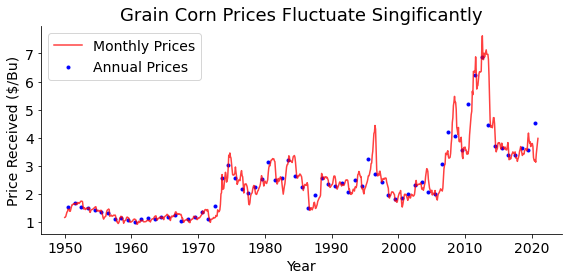

In [5]:
plt.figure(figsize=(8,4))
plt.scatter(
    annual_df_ts.index, 
    annual_df_ts['PRICE RECEIVED, MEASURED IN $ / BU'], 
    label='Annual Prices', 
    c='blue',
    marker='.'
)
plt.plot(
    monthly_df_ts.index, 
    monthly_df_ts['PRICE RECEIVED, MEASURED IN $ / BU'], 
    label='Monthly Prices', 
    c='red',
    alpha=0.75
)
plt.legend(fontsize=14)
plt.title('Grain Corn Prices Fluctuate Singificantly', size=18)
plt.xlabel('Year', size=14)
plt.ylabel('Price Received ($/Bu)', size=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
sns.despine()
plt.show()

Clearly, the price fluctuates over time and is generally trending up. However, it is interesting that the price essentially stagnated from about 1950 to 1970. It then rose dramatically in the 1970's, fluctuated wildly for the next 40 years, and then rose again in about 2009. There are some large spikes as well, especially around 2011 or so. I wonder how these fluctuations look when adjusted for inflation. I will look at that next for the annual prices.

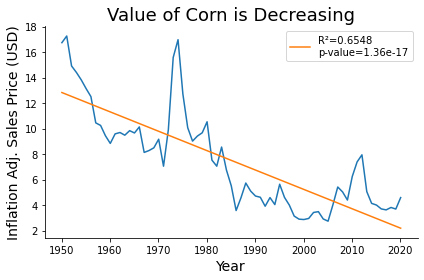

In [6]:
# Create an inflation multiplier column.
annual_df_ts['inflation multiplier'] = \
    (1 + annual_df_ts['Inflation Rate YOY']).iloc[::-1].cumprod().iloc[::-1]

# Create a column of prices adjusted for inflation.
annual_df_ts['adjusted price received'] = \
    annual_df_ts['PRICE RECEIVED, MEASURED IN $ / BU'] \
    * annual_df_ts['inflation multiplier']

# Create an int version of the datetime for linear regression.
X = annual_df_ts.index.strftime("%Y%m").astype('int') / 1E2

# Plot the adjusted sales price as a function of time.
plt.plot(X, annual_df_ts['adjusted price received'])

# Fit the data using least-squares regression.
slope, intercept, r_value, p_value, std_err = linregress(
    X, annual_df_ts['adjusted price received']
)

# Plot the best fit line
plt.plot(
    X, 
    X * slope + intercept, 
    label=f"R\u00b2={round(r_value**2,4)}\np-value={p_value:.3n}"
)

plt.xlabel('Year', size=14)
plt.ylabel('Inflation Adj. Sales Price (USD)', size=14)
plt.title('Value of Corn is Decreasing', size=18)
plt.legend()

plt.tight_layout()
sns.despine()
plt.show()

Wow! When adjusted for inflation, the sales price per bushel of grain corn has dropped significantly over the past 70 years. There are spikes in the data in the 1970's and just after 2010. The spike after 2010 was noted earlier, whereas this plot really brings out the spike in the 70's. Interestingly there were significant recessions in the US economy around these times. Perhaps during a recession recovery, grain prices go up?

I now want to make an interactive plot of price over time for the monthly data. For this, I will use `plotly express`, which was imported previously.

In [7]:
fig = px.line(
    monthly_df_ts, 
    x=monthly_df_ts.index, 
    y='PRICE RECEIVED, MEASURED IN $ / BU'
)

fig.update_layout(
    yaxis_title="Price Received per Bushel (USD)", 
    xaxis_title='Year',
    title="Price Received per Bushel of Grain Corn from 1950 to 2020"
)

fig.update_xaxes(rangeslider_visible=True)

fig.show()

The plot looks good. Plots like the one above can be really useful for dashboards that an executive or other business analyst might use to get a better look at the data without needing to do any programming. You can also generate quick images of this plot, which can be good for making presentations, etc. However, I would like to take this plot a little further. When combined with the `statsmodel` package, `plotly express` can find some interesting patterns over time. I'll use it now to look for monthly trends as well as see how much each month deviates from this trend.

In [8]:
# Instantiate the decomposition model.
decomposition = tsa.seasonal_decompose(
    monthly_df_ts['PRICE RECEIVED, MEASURED IN $ / BU'], 
    model='additive'
)

# Add the decomposed data to the dataframe as new columns.
monthly_df_ts["Monthly Trend in Bushel Price"] = decomposition.seasonal
monthly_df_ts["Residuals for Individual Months"] = decomposition.resid

# Define columns for plotting.
cols = ["Monthly Trend in Bushel Price", "Residuals for Individual Months"]

# Plot the data.
fig = make_subplots(rows=2, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=monthly_df_ts.index, y=monthly_df_ts[col]),
        row=i+1,
        col=1
    )
    
fig['layout']['yaxis']['title']='% Dev. from Annual Price'
fig['layout']['yaxis2']['title']='Residuals'

fig.update_layout(width=950, showlegend=False)
fig.show()

The trend plot shows average behaviors for each month relative to the overall annual behavior. This is not a month by month plot, but a plot of the overall average trend derived by looking at all months and years together. The residual plot shows how much each individual month deviates from that behavior. It seems like there is a simple monthly trend, where prices spike in June and are at their lowest in November. However, several months, especially in the 1970's and after 1995, deviate significantly from this trend. I think I would like the monthly trend plot simplified a little bit in case I wanted to use it in a presentation. I'll make the simpler plot next.

In [9]:
# Calculate monthly averages.
monthly_mean = monthly_df_ts['PRICE RECEIVED, MEASURED IN $ / BU'].groupby(
    monthly_df_ts.index.month_name()
).mean()

# Calculate relative deviations from the overall mean.
monthly_mean_diff = (monthly_mean - monthly_mean.mean())/monthly_mean

# Generate the month names in the correct order.
month_names = pd.date_range(start='1950-01-01' , freq='M', periods=12).month_name()

# Reorder the columns to follow the correct order of months.
monthly_mean_diff = monthly_mean_diff.loc[month_names, ]

fig = px.bar(monthly_mean_diff, width=700, height=400)

fig.update_layout(
    yaxis_title="Deviation",
    yaxis_tickformat = '%',
    xaxis_title="",
    font_color='black',
    title={
        'text': "Monthly Deviations from Annual Prices",
        'x': 0.5,
        'y': 0.9
    },
    showlegend=False
)

fig.update_xaxes(
    tickangle = 90
)

fig.show()

Great, now I have a plot that is simpler to read and understand. And again we see the same patterns. Prices are highest in June and lowest in November. This may have to do with temperature, with higher quality corn being harvested in the warmer summer months and lower quality corn being harvested in the colder months. However, additional factors may be impacting this other than just the quality of corn, such as shipping prices or other market variables not captured in the current data set.

I will now plot the sales price received for a given month during each year. This type of plot can be useful for spotting anomalous behavior, though it is likely too complicated to give to anyone that doesn't request it.

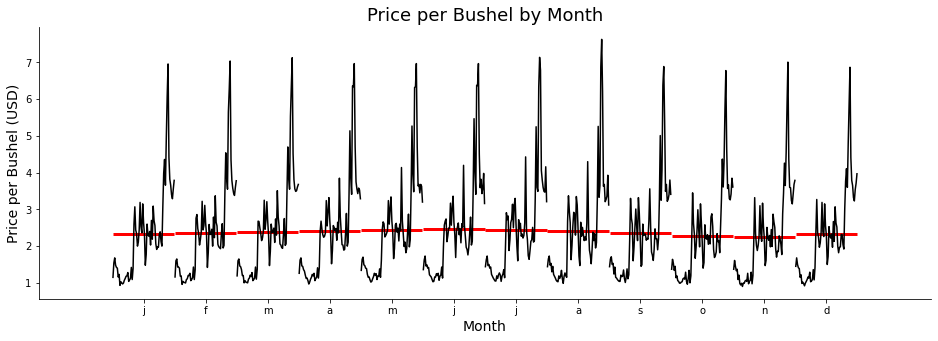

In [10]:
plt.figure(figsize=(16, 5))

month_plot(monthly_df_ts['PRICE RECEIVED, MEASURED IN $ / BU'], ax=plt.gca())

plt.title("Price per Bushel by Month", size=18)
plt.xlabel('Month', size=14)
plt.ylabel('Price per Bushel (USD)', size=14)
sns.despine()
plt.show()

An individual pattern is plotted for each month in the plot above. This pattern seems similar to the pattern observed for the average annual price received. Additionally, there do not appear to be any obvious anomalies in this data.

#### Other Grain Corn Data  

Here, I will explore the rest of the corn data taken from the USDA data repository, which was all only collected on an annual basis. These data include: `ACRES HARVESTED`, `PRODUCTION, MEASURED IN BU`, `PRODUCTION, MEASURED IN $`, and `YIELD, MEASURED IN BU / ACRE`. I think the best way to visualize these data is as a function of time. 

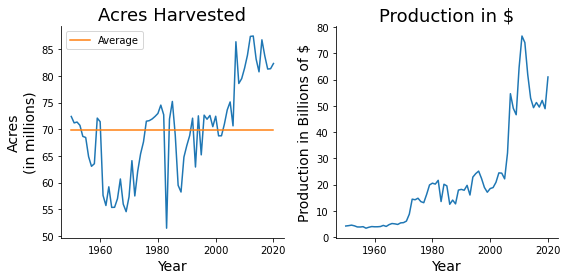

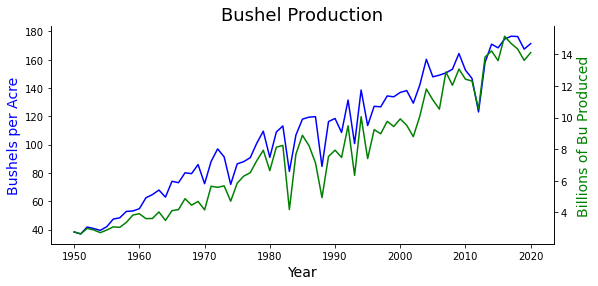

In [11]:
plt.subplots(2, figsize=(8,4))

plt.subplot(1,2,1)

avg_acres_harvested = np.mean(annual_df['ACRES HARVESTED'] / 1E6)

plt.plot(annual_df.index, annual_df['ACRES HARVESTED'] / 1E6)
plt.plot([1950,2020], [avg_acres_harvested,avg_acres_harvested], label='Average')
plt.title('Acres Harvested', size=18)
plt.xlabel('Year', size=14)
plt.ylabel('Acres\n(in millions)', size=14)
plt.legend()

plt.subplot(1,2,2)
plt.plot(annual_df.index, annual_df['PRODUCTION, MEASURED IN $'] / 1e9)
plt.title('Production in $', size=18)
plt.ylabel('Production in Billions of $', size=14)
plt.xlabel('Year', size=14)
plt.tight_layout()
sns.despine()
plt.show()

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(annual_df.index, annual_df['YIELD, MEASURED IN BU / ACRE'], color='blue')
ax.set_title('Bushel Production', size=18)
ax.set_xlabel('Year', size=14)
ax.set_ylabel('Bushels per Acre', color='blue', size=14)

ax2 = ax.twinx()
ax2.plot(annual_df.index, annual_df['PRODUCTION, MEASURED IN BU'] / 1e9, color='green')
ax2.set_ylabel('Billions of Bu Produced', color='green', size=14)

sns.despine(right=False)
plt.show()

Interestingly, the number of acres harvested each year has not changed much, even though all metrics of production, including total revenue, bushels harvested, and bushels harvested per acre, have all increased significantly with time. In fact, there was a large drop in acres harvested in the 1960's that didn't correct itself until the mid 1970's. A similar drop is not seen in the number of bushels produced, meaning that at this time farmers were either gaining or developing more efficient farming techniques that allowed them to harvest more corn from the same plot of land. Similarly, the number of acres harvested dropped and came back up several times between the mid 1970's and about 2005, even though production generally rose during this period, suggesting more technological advancements were being made. More land wasn't harvested until about the mid 2000's, at which point demand likely caught up with farming advancements. 

Production measured in $ (or total revenue) has generally increased. This is likely due to a combination of inflation and population growth. More than likely the steady increase in the number of bushels produced each year, as seen in the bottom frame, is due to population growth. I want to see how production and population compare now. For this plot, I will only use the total number of bushels produced, as that should have the most direct correlation with population size.

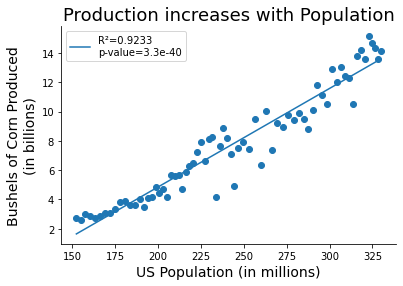

In [12]:
plt.scatter(
    annual_df['USPop'] / 1000000, 
    annual_df['PRODUCTION, MEASURED IN BU'] / 1000000000
)
slope, intercept, r_value, p_value, std_err = linregress(
    annual_df['USPop'] / 1000000, 
    annual_df['PRODUCTION, MEASURED IN BU'] / 1000000000
)
plt.plot(
    annual_df['USPop'] / 1000000, 
    annual_df['USPop'] / 1000000 * slope + intercept, 
    label=f"R\u00b2={round(r_value**2,4)}\np-value={p_value:.3n}"
)
plt.legend()

plt.title('Production increases with Population', size=18)
plt.xlabel('US Population (in millions)', size=14)
plt.ylabel('Bushels of Corn Produced\n(in billions)', size=14)

sns.despine()
plt.show()

Well, those definitely seem strongly correlated. US population and bushel production have an R<sup>2</sup> value of 0.92, meaning that the line drawn between the data accounts for 92% of the relationship between these two factors. It is a little surprising that the population is so strongly correlated with corn grain production, since one would assume some of the corn is exported as well. According to the website [ers.usda.gov](https://www.ers.usda.gov/topics/crops/corn-and-other-feedgrains/feedgrains-sector-at-a-glance/), only about 10% to 20% of US corn is exported. Thus, most of the corn is consumed domestically, which explains the strong correlation observed in the above plot.

#### Cooling & Heating Degree Days

I will now visualize the cooling and heating degree day data. These are metrics of how much the outside temperature is above or bellow a given temperature (usually 65 $^{\circ}$F) multiplied by the number of days it is above or bellow that temperature. Cooling degree days are days that are above 65 $^{\circ}$F, wherein a building would need to be cooled, and heating degree days are days that are above 65 $^{\circ}$F. These values are reported in units of $^{\circ}$F days. I'm now going to visualize the distribution of heating day and cooling day values over the different months and years using histograms.

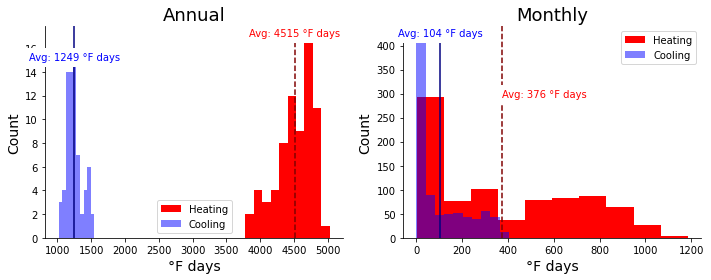

In [13]:
plt.subplots(2, figsize=(10,4))

for i, period in enumerate([annual_df, monthly_df]):
    plt.subplot(1,2,i+1)
    heating = plt.hist(
        period['Heating Degree Days'], 
        color='red', 
        label='Heating'
    )
    heating_max = heating[0].max()
    plt.axvline(period['Heating Degree Days'].mean(), c='maroon', ls='--')
    
    cooling = plt.hist(
        period['Cooling Degree Days'], 
        color='blue', 
        alpha=0.5, 
        label='Cooling'
    )
    cooling_max = cooling[0].max()
    plt.axvline(period['Cooling Degree Days'].mean(), c='navy', ls='-')
    
    plt.text(
        period['Heating Degree Days'].mean(), 
        heating_max, 
        f"Avg: {int(round(period['Heating Degree Days'].mean(),0))} \N{DEGREE SIGN}F days", 
        backgroundcolor='white',
        color='red',
        ha='center' if heating_max < 50 else 'left'
    )
    plt.text(
        period['Cooling Degree Days'].mean(), 
        cooling_max, 
        f"Avg: {int(round(period['Cooling Degree Days'].mean(),0))} \N{DEGREE SIGN}F days",
        backgroundcolor='white',
        color='blue',
        ha='center'
    )
    
    plt.title('Annual' if i == 0 else 'Monthly', size=18)
    plt.ylabel('Count', size=14)
    plt.xlabel(u'\N{DEGREE SIGN}F days', size=14)
    plt.legend()

plt.tight_layout()
sns.despine()
plt.show()

Interestingly the amount of heating days is significantly higher than the number of cooling days in the united states. The average amount of cooling days per year is 1249 $^{\circ}$F days, whereas the average amount of heating days is 4515 $^{\circ}$F days, a more than 3-fold higher number. A similar observation is made for the monthly data, wherein the average amount of heating days is 376 $^{\circ}$F days, whereas the amount of cooling days is nearly 4-fold less at 104 $^{\circ}$F days. These results mean that the US spends more time heating buildings than cooling them down. Unsurprisingly, the distribution of values is more tight for the annual data than the monthly data for both heating and cooling degree days. This is simply because temperature fluctuates month to month but is hopefully somewhat constant year to year.  

As stated above, the US spends more time heating building than cooling them down. I would now like to see a pie chart showing the percentage of heating degree days vs cooling degree days to see where most of the electricity in the US is being spent in terms of air conditioning.

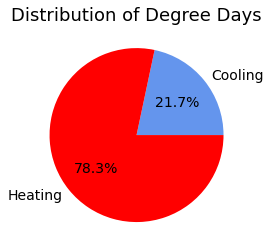

In [14]:
# Calculate sum of heating and cooling degree days.
cooling_days = np.sum(annual_df['Cooling Degree Days'])
heating_days = np.sum(annual_df['Heating Degree Days'])

# Normalize the sums.
pct_cooling = cooling_days / (cooling_days + heating_days) * 100
pct_heating = 100 - pct_cooling

plt.pie(
    [cooling_days, heating_days], 
    labels=[
        f'Cooling',
        f'Heating'
    ], 
    colors=['cornflowerblue','r'],
    textprops = {"fontsize":14},
    autopct = "%0.1f%%"
    
)
plt.title('Distribution of Degree Days', size=18)
plt.show()

This pie chart shows that 78.3% of the degree days are heating degree days and only 21.7% are cooling degree days. Because heating and cooling can require different amounts of energy to affect the same change in temperature and because there are multiple methods of both heating and cooling used in the United States, this plot is not exactly the same as the amount of energy used for heating and cooling as a percentage of total air conditioning energy. However, it does give some insight into the amounts of energy used for both heating and cooling.  

There is likely a correlation between the amount of heating degree days and cooling degree days in a given month or year. I say this because if the current temperature results in a heating degree day it cannot be resulting in a cooling degree and vice versa. I will now plot these two variables as functions of one another for both the annual and monthly data.

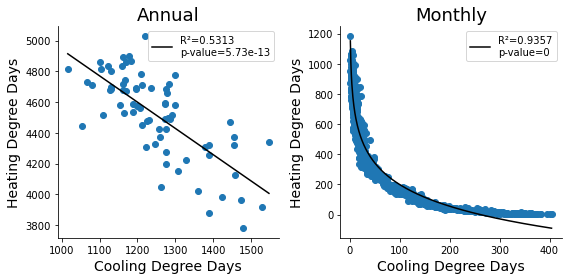

In [15]:
plt.subplots(2, figsize=(8,4))

for i, period in enumerate([annual_df, monthly_df]):
    plt.subplot(1,2,i + 1)
    plt.scatter(period['Cooling Degree Days'], period['Heating Degree Days'])
    slope, intercept, r_value, p_value, std_err = linregress(
        period['Cooling Degree Days'] if i == 0 else np.log(period['Cooling Degree Days']), 
        period['Heating Degree Days'] 
    )
    x = period['Cooling Degree Days'].sort_values()
    plt.plot(
        x,
        (x if i == 0 else np.log(x)) * slope + intercept, 
        label=f"R\u00b2={round(r_value**2,4)}\np-value={p_value:.3n}",
        c='black'
    )
    plt.xlabel('Cooling Degree Days', size=14)
    plt.ylabel('Heating Degree Days', size=14)
    plt.title('Annual' if i == 0 else 'Monthly', size=18)
    plt.legend()

plt.tight_layout()
sns.despine()
plt.show()

Interestingly, for the annual data the amount of heating degree days appears to have a negative linear correlation with the amount of cooling degree days. However, for the monthly data, these features have an inverse relationship with one another. It should be noted that for the annual data, an R<sup>2</sup> value of only 0.53 was obtained, whereas for the monthly data an R<sup>2</sup> value of 0.94 was obtained, indicating a much stronger correlation for the monthly data than for the annual data. It is interesting that there is such a strong correlation on a monthly basis but not on a yearly basis. This loss in correlation likely results from the annual data being an aggregate of all of the monthly data, and the information is likely somewhat scrambled (loses correlation) during the aggregation. Still, very low p-values were obtained for both plots, indicating that there still is a significant correlation between the data.

#### Precipitation

I will now visualize the precipitation feature for both the annual and monthly data. To start, I will be plotting these values as a function of time using line plots. I will also extract the average precipitation per month and plot that data as a function of the month as well.

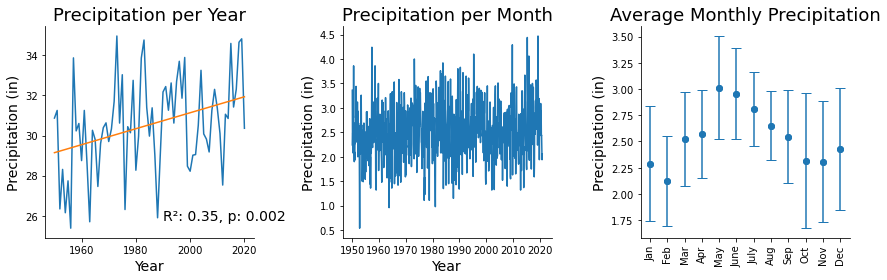

In [16]:
# Create a list of month numbers.
months = np.arange(1,13)

# Create lists for holding average and standard deviations of monthly data.
avg_monthly_precipitation = [] # This is slightly faster than the formal list declaration shown in the next line.
stdev_monthly_precipitation = list() 

for mon in months:
    sub_df = monthly_df[monthly_df.index.month == mon]
    
    avg_precip = np.mean(sub_df['Precipitation'])
    avg_monthly_precipitation.append(avg_precip)
    
    stdev_precip = np.std(sub_df['Precipitation'])
    stdev_monthly_precipitation.append(stdev_precip)
    

plt.subplots(3, figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(annual_df.index, annual_df['Precipitation'])
slope, intercept, r_value, p_value, std_err = linregress(annual_df.index, annual_df['Precipitation'])
plt.plot(annual_df.index, annual_df.index * slope + intercept)
plt.text(1990,25.8,f"R\u00b2: {round(r_value,2)}, p: {round(p_value,3)}", size=14)
plt.title('Precipitation per Year', size=18)
plt.xlabel('Year', size=14)
plt.ylabel('Precipitation (in)', size=14)

plt.subplot(1,3,2)
plt.plot(monthly_df.index, monthly_df['Precipitation'])
plt.title('Precipitation per Month', size=18)
plt.xlabel('Year', size=14)
plt.ylabel('Precipitation (in)', size=14)

plt.subplot(1,3,3)
plt.scatter(months, avg_monthly_precipitation)
plt.errorbar(months, avg_monthly_precipitation, yerr=stdev_monthly_precipitation, fmt="o", capsize=5)
plt.xticks(
    ticks=np.arange(1,13), 
    labels=['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec'],
    rotation='vertical'
)
plt.title('Average Monthly Precipitation', size=18)
plt.ylabel('Precipitation (in)', size=14)

plt.tight_layout()
sns.despine()
plt.show()

The annual precipitation fluctuates year to year but generally stays between about 25 and 35 inches per year. Interestingly, there appears to be a somewhat of an upward trend in the amount of rain fall year over year. This may be an actual phenomenon, but with an R<sup>2</sup> value of only 0.35, this is likely just a statistical coincidence. But according to the p-value, there is only a 0.2% chance of observing this trend by pure chance without some outside cause. Interesting.

As expected, the monthly precipitation varies significantly, thus making the middle plot fairly uninformative, except for maybe deriving an average rainfall of about 2.5 in. In the third plot, the average rainfall per month is shown, with error bars corresponding to one standard deviation. The highest rainfall is seen in May, one month before the highest prices are received for corn. It is unclear at this point, however, whether those two features (monthly precipitation and price per bushel) are correlated.  

Since there is variation in rainfall, I would like to look at the distribution of possible values for precipitation. For this, I will use histograms.

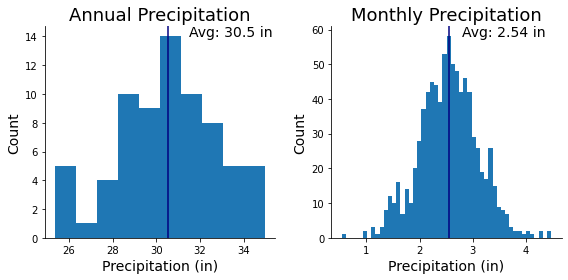

In [17]:
plt.subplots(2, figsize=(8,4))

plt.subplot(1,2,1)
plt.hist(annual_df['Precipitation'])
plt.title('Annual Precipitation', size=18)
plt.ylabel('Count', size=14)
plt.xlabel('Precipitation (in)', size=14)
plt.axvline(annual_df['Precipitation'].mean(), c='navy', ls='-')
plt.text(31.5, 14, f"Avg: {round(annual_df['Precipitation'].mean(),1)} in", fontsize=14)

plt.subplot(1,2,2)
plt.hist(monthly_df['Precipitation'], bins=50)
plt.title('Monthly Precipitation', size=18)
plt.ylabel('Count', size=14)
plt.xlabel('Precipitation (in)', size=14)
plt.axvline(monthly_df['Precipitation'].mean(), c='navy', ls='-')
plt.text(2.8, 58, f"Avg: {round(monthly_df['Precipitation'].mean(),2)} in", fontsize=14)

plt.tight_layout()
sns.despine()
plt.show()

Here, we see that the average annual rainfall in 30.5 in and ranges from about 26 to 35 in. The monthly rainfall has an average of 2.54 in, with values ranging from just above 0 in to just under 5 in. I wonder how the rainfall differs for different months. I could try putting all of that data on one plot, but there would likely be too much overlapping data for the plot to be any useful. So, I will generate separate histograms for each month.

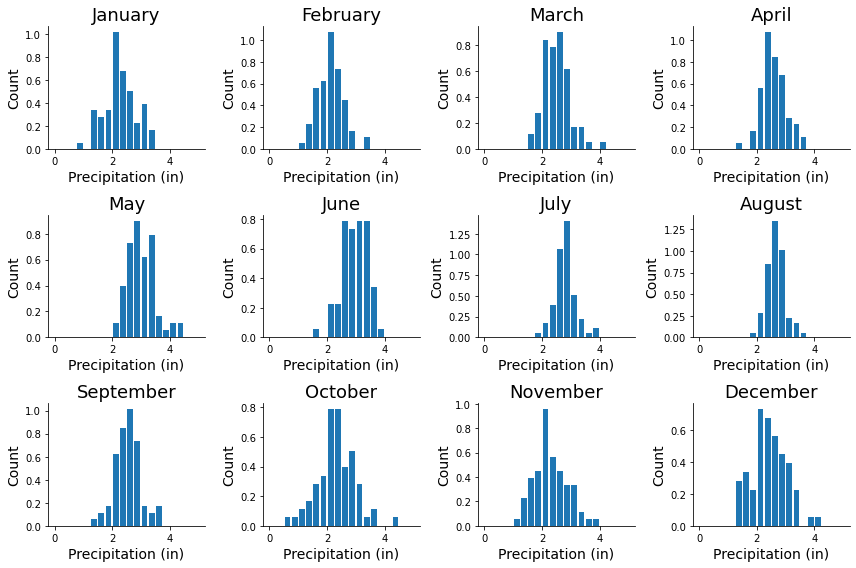

In [18]:
import calendar
month_names = list(calendar.month_name[1:])

plt.subplots(12, figsize=(12,8))
for i, month in enumerate(month_names):
    plt.subplot(3,4,i+1)
    plt.hist(
        monthly_df_ts[monthly_df_ts.index.month_name() == month]['Precipitation'], 
        range=(0,5), 
        bins=20, 
        density=True,
        rwidth=0.8
    )
    plt.ylabel('Count', size=14)
    plt.xlabel('Precipitation (in)', size=14)
    plt.title(month, size=18)


plt.tight_layout()
sns.despine()
plt.show()

I can now look at the distribution of values for rainfall month by month.

#### Palmer Drought Severity Index (PDSI)

I will now look at the Palmer Drought Severity Index, or PDSI for short. PDSI is a measure of relative dryness. As such, it likely fluctuates with time. I will make an interactive time series plot for this data, along with a plot in seasonal trends and monthly residuals. I will do this using `plotly`'s `graph_objs` package.

In [19]:
decomposition_PDSI = tsa.seasonal_decompose(monthly_df_ts['Palmer Drought Severity Index (PDSI)'], model='additive')

monthly_df_ts["Trend in PDSI, Month by Month"] = decomposition_PDSI.trend
monthly_df_ts["Seasonal PDSI Pattern"] = decomposition_PDSI.seasonal
monthly_df_ts["Monthly Residual from the Seasonal PDSI Pattern"] = decomposition_PDSI.resid

cols = ["Trend in PDSI, Month by Month", "Seasonal PDSI Pattern", "Monthly Residual from the Seasonal PDSI Pattern"]

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=monthly_df_ts.index, y=monthly_df_ts[col]),
        row=i+1,
        col=1
    )

fig.update_layout(width=800, showlegend=False, yaxis_title="PDSI", yaxis2_title="PDSI", yaxis3_title="Residual")

fig.show()

The PDSI fluctuates between a minimum value of about -5 and a maximum value of about 5. The average trend is a low in March and a high in Dec. However, the residuals for this series are huge. The seasonal trend ranges from just under 0.2 to just under -0.2, but the residuals range from about 3 to just above -5. Thus it is hard to put much confidence in the seasonal trend. I should look at a breakdown of monthly PDSI.

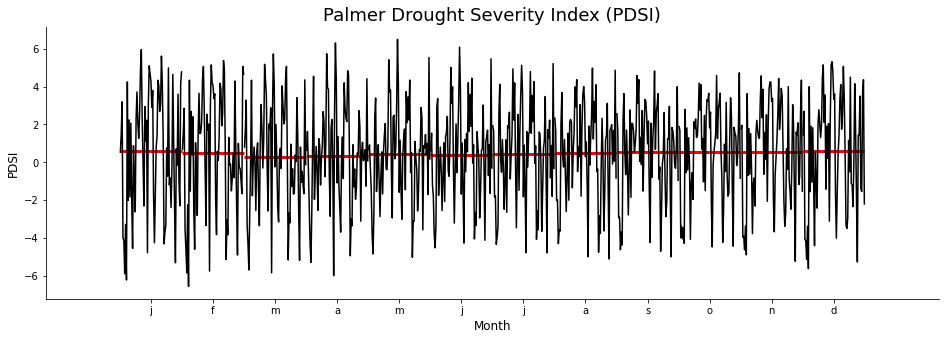

In [20]:
plt.figure(figsize=(16, 5))

# create the seasonal plot
month_plot(monthly_df_ts['Palmer Drought Severity Index (PDSI)'], ax=plt.gca())

plt.title('Palmer Drought Severity Index (PDSI)', size=18)
plt.xlabel('Month', size=12)
plt.ylabel('PDSI', size=12)
sns.despine()
plt.show()

Interesting. The monthly plot has a larger range than the annual plot, with maxima and minima at around 6 and -6, respectively. There also does not appear to be any general trend with month, as the average PDSI is approximately the same for each month. I wonder if the PDSI correlates with the precipitation data. I will plot this next using a scatter plot on a monthly basis.

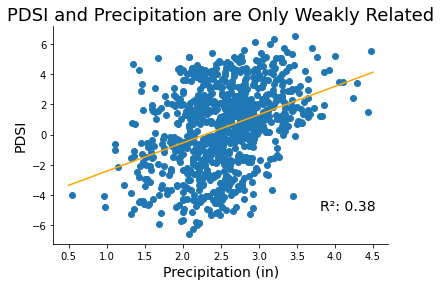

In [21]:
plt.scatter(monthly_df['Precipitation'], monthly_df['Palmer Drought Severity Index (PDSI)'])
slope, intercept, r_value, p_value, std_err = linregress(monthly_df['Precipitation'], monthly_df['Palmer Drought Severity Index (PDSI)'])
plt.plot([0.5,4.5],np.array([0.5,4.5]) * slope + intercept, c='orange')
plt.text(3.8,-5, f"R\u00b2: {round(r_value,2)}", size=14)
plt.title('PDSI and Precipitation are Only Weakly Related', size=18)
plt.ylabel('PDSI', size=14)
plt.xlabel('Precipitation (in)', size=14)
sns.despine()
plt.show()

There is a very low correlation between PDSI and precipitation. That is a surprising result, since precipitation should decrease dryness. A possible explanation of this is that the average dryness over the month includes many dry days even after some wet days.

#### Max, Min, & Average Temperature

I will now look at how the temperature changes over time. Here I have three metrics: `maximum temperature`, `minimum temperature`, and `average temperature`. None of these should change much year to year. To check this assumption I will plot all of these values vs year.

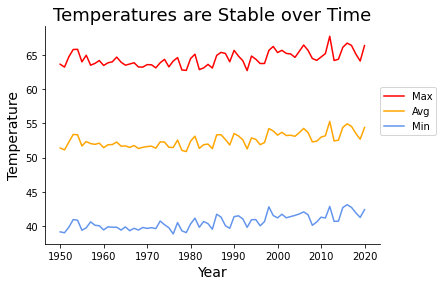

In [22]:
plt.plot(annual_df.index, annual_df['Maximum Temperature'], color='red', label='Max')
plt.plot(annual_df.index, annual_df['Average Temperature'], color='orange', label='Avg')
plt.plot(annual_df.index, annual_df['Minimum Temperature'], color='cornflowerblue', label='Min')
plt.title('Temperatures are Stable over Time', size=18)
plt.xlabel('Year', size=14)
plt.ylabel('Temperature', size=14)
plt.legend(loc=(1.0,0.5))
sns.despine()
plt.show()

As expected, all three values are relatively constant with minor fluctuations year to year. The maximum temperature is around 65 $^{\circ}$F, the average is around 53 $^{\circ}$F, and the minimum is around 40 $^{\circ}$F. I will now look at these three metrics on a monthly basis. They should all change by month.

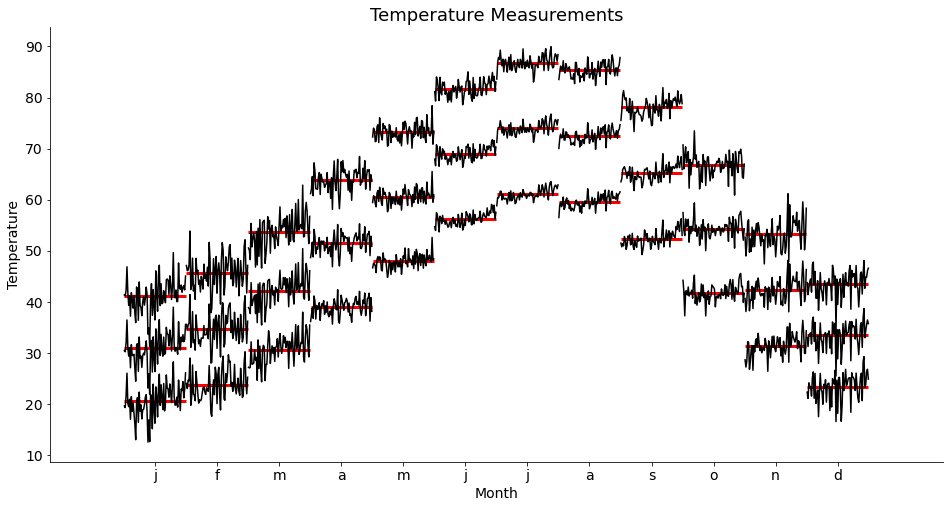

In [23]:
plt.figure(figsize=(16, 8))

# create the seasonal plot
month_plot(monthly_df_ts['Maximum Temperature'], ax=plt.gca())
month_plot(monthly_df_ts['Average Temperature'], ax=plt.gca())
month_plot(monthly_df_ts['Minimum Temperature'], ax=plt.gca())

plt.title('Temperature Measurements', size=18)
plt.xlabel('Month', size=14)
plt.ylabel('Temperature', size=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
sns.despine()
plt.show()

This plot may be a little difficult to interpret since the data isn't really labeled as max, min, or average, but this is a very informative plot. The minimum values are always on the bottom, the averages in the middle, and the maximum on top. These metrics fluctuate for a given month, but the fluctuation is much more dramatic over the course of the year. This is what we would expect: hot in summer and cold in winter.

#### GDP & Percent GDP

I now want to look at how the gross domestic product (and % change in GDP) change with time. I will first plot the annual GDP vs time.

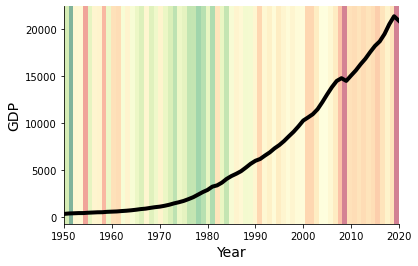

In [24]:
ax = annual_df['GDP'].plot()

ax.plot(annual_df.index, annual_df['GDP'], color='black', linewidth=4)
ax.set_xlabel('Year', size=14)
ax.set_ylabel('GDP', size=14)
ax.set_xlim(1950,2020)
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
              annual_df['GDP_PCH'].values[np.newaxis],
              cmap='RdYlGn', alpha=0.5)

sns.despine()
plt.show()

In the above plot it can be hard to see tiny fluctuations, so I highlighted the background relative to the percent of change GDP experienced vs the previous year. Green indicates significant growth, red significant loss, with yellow and orange as intermediate values. This plotting scheme makes it easier to see things like the loss in GDP experienced in 1955 and 1959, which would otherwise be impossible to see with the normal line plot. Generally, GDP increases year over year as population grows and inflation continues to rise.

I'm interested now in seeing how the annual change in GDP compares to the monthly change.

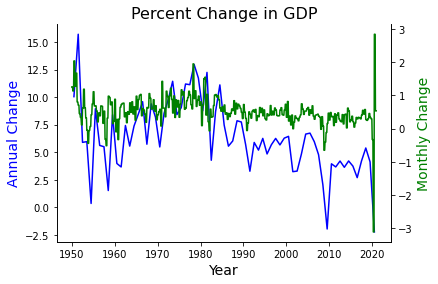

In [25]:
fig, ax = plt.subplots()
ax.plot(annual_df_ts.index, annual_df_ts['GDP_PCH'], color='blue')
ax.set_title('Percent Change in GDP', size=16)
ax.set_xlabel('Year', size=14)
ax.set_ylabel('Annual Change', color='blue', size=14)

ax2 = ax.twinx()
ax2.plot(monthly_df.index, monthly_df['GDP_PCH'], color='green')
ax2.set_ylabel('Monthly Change', color='green', size=14)

sns.despine(right=False)
plt.show()

Unsurprisingly, these values exhibit somewhat similar patterns, with the annual changes essentially acting as a magnification of monthly changes. The monthly change in GDP was high in the early 1950's but has hovered between just under 0% and just over 1% since then. The exception is the dramatic drop and subsequent dramatic rise seen at the end of 2020.

#### Inflation

I now want to visualize the annual and monthly inflation rates. I will do this over time using `plotly`'s `subplot` package.

In [26]:
fig = make_subplots(rows=2, cols=1, subplot_titles=[
    'Year-Over-Year Inflation Rates', 
    'Month-Over-Month Inflation Rates'
])

fig.add_trace(
    go.Scatter(x=annual_df_ts.index, y=annual_df_ts['Inflation Rate YOY']),
    row=1,
    col=1
)

fig.add_trace(
    go.Scatter(x=monthly_df_ts.index, y=monthly_df_ts['Inflation Rate']),
    row=2,
    col=1
)

fig.update_layout(width=600, showlegend=False, xaxis_title="Year", yaxis_title='%', yaxis2_title='%')

fig.show()

There does not appear to be any real pattern to the fluctuations in period-over-period inflation rates. This is to be expected, as the market tends to fluctuate based on outside forces. The flat lines are seen in the monthly plot because of the way monthly inflation rates were calculated from quarterly inflation.

#### US Population

The population of the United States has been increasing for years. There should be a simple relationship with this value and time.

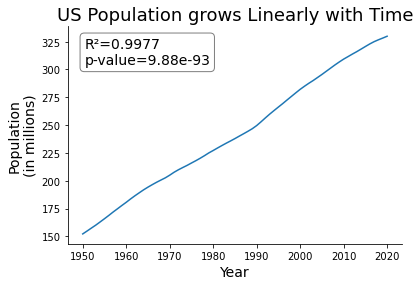

In [27]:
slope, intercept, r_value, p_value, std_err = linregress(
    annual_df.index,
    annual_df['USPop']
)

fig, ax = plt.subplots()

ax.plot(annual_df.index, annual_df['USPop'] / 1e6)
textstr = f"R\u00b2={round(r_value**2,4)}\np-value={p_value:.3n}"

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='w', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_ylabel('Population\n(in millions)', size=14)
ax.set_xlabel('Year', size=14)
ax.set_title('US Population grows Linearly with Time', size=18)

sns.despine()
plt.show()

As expected, the population increases over time. I am amazed at how linear this growth has been (R<sup>2</sup> = 0.998). The population was about 150 million in 1950 and is now over 325 million.  

I calculated the monthly US population from the annual data, so I'm not going to plot that data at this time (since it should have an identical trend).

## Comparison to the target variable

In this section I want to compare the various feature to the target value, `PRICE RECEIVED, MEASURED IN $ / BU`. Specifically, I am going to be plotting them against the target value, performing linear regression, and check the resulting p-value to see whether or not I should use the features for modeling the target. Specifically, I will be evaluating the null and alternate hypotheses.

- H<sub>0</sub> (*null hypothesis*): there <u>is **no** correlation</u> between the target feature and the feature of interest.  
- H<sub>1</sub> (*alternative hypothesis*): there <u>is **a** correlation</u> between the target feature and the feature of interest.  

If there is a p-value of 0.05, then I can be 95% confident that there is a correlation between the variables. The 0.05 value is known as $ \alpha $ (alpha). $ \alpha $ is a preselected threshold for determining where to cut off your results. Therefore, $ \alpha $ does not need to be 0.05, but this is the most commonly used value.  

If the p-value is greater than 0.05, I will be unable to reject the null hypothesis, but if the p-value is less than or equal to 0.05, I can reject the null hypothesis. Therefore, I will be filtering for features with a p-value less than or equal to 0.05. 

To make this analysis simpler, I will list to keep track of which features to keep. I will also be writing a function that will make plots of the data, performs linear regression, and removes values from the list if their p-values are bellow $ \alpha $.

In [28]:
# Generate lists of annual and monthly keepers.
annual_keepers = []
monthly_keepers = []

# Define the function to compare features vs the target variable.
def vs_target(feature1, feature2='empty', color='blue'):
    """
    Returns plots of the given feature vs the target variable ("PRICE RECEIVED, MEASURED IN $ / BU")
    for the annual and monthly data. These plots include a best fit line to the data calculated using
    the least squares method. Finally, the function removes the given feature from the respective
    keeper list if the p-value is greater than 0.05.
    
    Args:
        feature1 (str): the name of the feature as it appears in the annual dataframe.
        feature2 (str, optional): the name of the feature as it appears in the monthly dataframe. If no name 
            is provided, the function tries setting this string equal to feature1. If feature1 does not exist
            in the annual dataframe, the function prints a message indicating this.
        color (str, optional): sets the color of the markers on the plot. No other customization is available. 
            Default value is 'blue'.
    
    Returns:
        No return value.
    """
    
    # Check if feature2 is empty. If it is, set feature2=feature1.
    if feature2 == 'empty':
        feature2 = feature1
    
    # By default, the function assumes there is a value for feature2. Hence, warning is set to false.
    show_warning=False
    
    # Create the subplots with the appropriate figure size.
    plt.subplots(2, figsize=(8,4))
    
    # Iterate over the two feature names.
    for i, feature in enumerate([feature1, feature2]):
        
        # Check if we are on the annual or monthly dataframe.
        if i == 0:
            df = annual_df
        else:
            df = monthly_df
        
        # Check if the feature is in the given dataframe.
        if feature in df.columns:
            
            # Add a subplot to the plot.
            plt.subplot(1,2,i+1)
            
            # Give the plot a title and x- and y-axis labels
            plt.title(feature + f"\nvs Price Received {'(annual)' if i == 0 else '(monthly)'}", size=18)
            plt.xlabel(feature, size=14)
            plt.ylabel('Price Received (USD)', size=14)
            
            # Perform linear regression.
            slope, intercept, r_value, p_value, std_err = linregress(
                df[feature], 
                df['PRICE RECEIVED, MEASURED IN $ / BU']
            )
            
            # Calculate the minimum and maximum values of the given feature, and use these values
            # to generate a range for plotting the best fit line.
            minimum = min(df[feature])
            maximum = max(df[feature])
            x_range = np.arange(minimum, maximum * 1.01, (maximum-minimum)/10)
            
            # Plot the best fit line.
            plt.plot(x_range, slope*x_range + intercept, color='DarkSlateGray', ls='--')
            
            # Plot the actual data.
            plt.scatter(
                df[feature], 
                df['PRICE RECEIVED, MEASURED IN $ / BU'], 
                color=color,
                label=f"slope={slope:.2e}\nR\u00b2={round(r_value**2,4)}\np-value={p_value:.3n}"
            )
            
            # Add the legend.
            plt.legend(markerscale=0, handletextpad=-1)
            
            # Check if the p-value is greater than 0.05.
            if p_value <= 0.05:
                
                # If the p-value is greater than 0.05, add the feature to the corresponding
                # keeper list.
                if i == 0:
                    annual_keepers.append(feature)
                else:
                    monthly_keepers.append(feature)
        
        # If the feature is not in the dataframe, turn show_warning to true.
        else:
            show_warning = True
    
    # Clean up the figure.
    plt.tight_layout()
    sns.despine()
    
    # Show the figure.
    plt.show()
    
    # If the feature is not in the dataframe, print the following notification.
    # Note, this function is really only built to check if the feature is missing from the monthly
    # dataframe. I can only get away with this because I am the only one using this function. I 
    # would make this feature more robost if it were going to be used for general use.
    if show_warning:
        print(f'***No monthly equivelant for {feature!r}.***')

The function is now ready to go and I can apply it to the various features. I will start by looking at the 4 features obtained from the USDA data repository for grain corn (`ACRES HARVESTED`, `PRODUCTION, MEASURED IN BU`, `PRODUCTION, MEASURED IN $`, and `YIELD, MEASURED IN BU / ACRE`). These features were only collected on an annual basis. so the function should show a message stating there is no equivalent monthly feature.

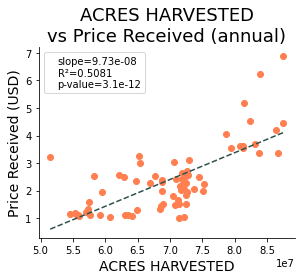

***No monthly equivelant for 'ACRES HARVESTED'.***


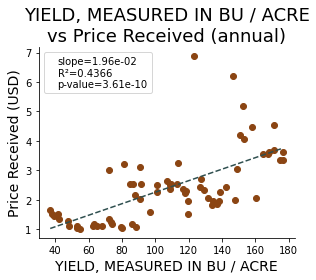

***No monthly equivelant for 'YIELD, MEASURED IN BU / ACRE'.***


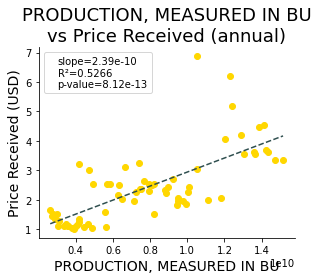

***No monthly equivelant for 'PRODUCTION, MEASURED IN BU'.***


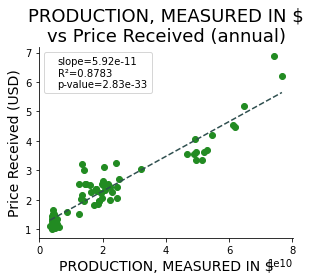

***No monthly equivelant for 'PRODUCTION, MEASURED IN $'.***


In [29]:
vs_target('ACRES HARVESTED', color='Coral')
vs_target('YIELD, MEASURED IN BU / ACRE', color='SaddleBrown')
vs_target('PRODUCTION, MEASURED IN BU', color='Gold')
vs_target('PRODUCTION, MEASURED IN $', color='ForestGreen')

The function `vs_target` appears to be working correctly. Plots were generated for the given features. The data were fit with best fit lines. Regression statistics are shown. And a message was shown, saying there's no monthly equivalent. Interestingly, all of these features have R<sup>2</sup> values around 0.5 except for the `PRODUCTION, MEASURED IN $`, which has an R<sup>2</sup> value of 0.88. Thus, the linear regression lines are able to account for about 50% of the variability in the data for the first 3 features and about 88% of the variability for the last feature.

The p-values of these features are all well bellow $ \alpha $=0.05. Therefore, we can reject the null hypothesis and add these features to the keeper list. I will check to make sure the function added the features to the annual list but not the monthly list.

In [30]:
display(annual_keepers, monthly_keepers)

['ACRES HARVESTED',
 'YIELD, MEASURED IN BU / ACRE',
 'PRODUCTION, MEASURED IN BU',
 'PRODUCTION, MEASURED IN $']

[]

Excellent. The features were added appropriately. 

I will now compare cooling and heating degree days to the target.

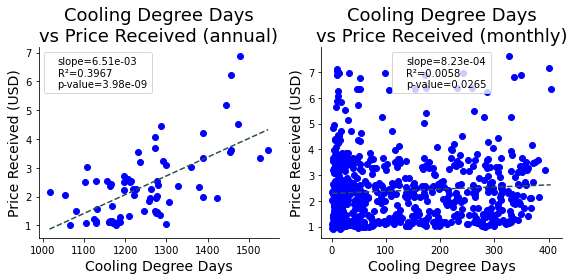

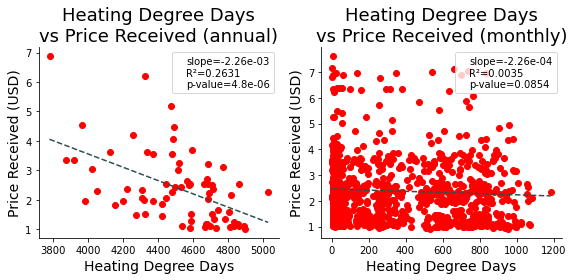

In [31]:
vs_target('Cooling Degree Days')
vs_target('Heating Degree Days', color='red')

This time, the function made plots for the monthly data as well because these climate features were collected both annually and monthly. For the annual data the cooling degree days have a positive linear correlation with the target, while the heating degree days have a negative correlation with the target. This inverse relationship is to be expected. These annual plots have somewhat low R<sup>2</sup> values (<0.4). However, their p-values are well bellow $ \alpha $. Therefore, for these data we reject the null hypothesis and add these data to the annual keeper list.  

A different story is seen for the monthly data. There is still a positive slope between cooling degree days and the target and a negative slope between heating degree days and the target. However, the R<sup>2</sup> values for these plots are very low (<0.01). While it may be tempting to reject these data at this point, the criteria that was set up at the beginning of this exercise was that features would only be removed if their p-value was less than $ \alpha $=0.05. For the cooling degree day data, the p-value is just bellow $ \alpha $ at 0.027. Therefore, for this feature we can reject the null hypothesis. However, for the heating degree day data, the p-value is above $ \alpha $ at 0.085. Therefore, for this data we fail to reject the null hypothesis. Therefore, only the cooling degree days should be added to the keeper list.  

I will do a quick check to see that the keeper lists were updated correctly.

In [32]:
display(annual_keepers, monthly_keepers)

['ACRES HARVESTED',
 'YIELD, MEASURED IN BU / ACRE',
 'PRODUCTION, MEASURED IN BU',
 'PRODUCTION, MEASURED IN $',
 'Cooling Degree Days',
 'Heating Degree Days']

['Cooling Degree Days']

The lists were updated correctly. Going forward, I will only check that the lists were updated properly at the end of this section.  

I will now look at the correlation between precipitation and the target.

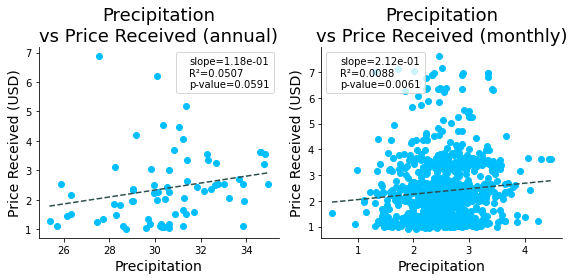

In [33]:
vs_target('Precipitation', color='deepskyblue')

Surprisingly, the precipitation is a poor predictor of price received for both the annual and monthly data. The R<sup>2</sup> value for the annual data is only 0.05, whereas for the monthly data it is even lower at 0.009. Thus, the best fit lines for both of these plots account for less than 10% of the variability. The p-value for the annual data is just above $ \alpha $ at 0.06, whereas for the monthly data the p-value is about an order of magnitude below $ \alpha $. Therefore, precipitation is kept as a feature for the monthly data but not for the annual data. 

I can now take a look at the Palmer drought severity index, which is a measure of relative dryness. 

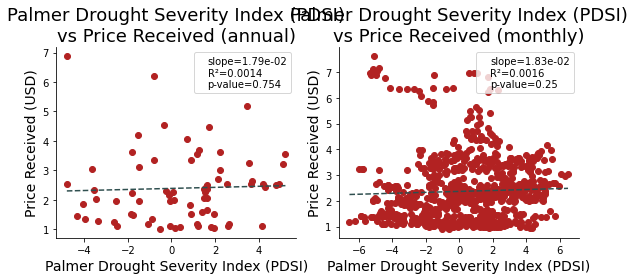

In [34]:
vs_target('Palmer Drought Severity Index (PDSI)', color='firebrick')

The PDSI also appears to be a poor predictor of the target. For both the annual and monthly data, the p-value is well above $ \alpha $. For the annual data the p-value is 0.75, and for the monthly data it is 0.25. Therefore, I fail to reject the null hypothesis for these data. These features will not be used for modeling. Additionally, the R<sup>2</sup> values for these plots are both less than 0.01, meaning these features have exceptionally low predictive power for the target.  

The next features I will examine are the temperature features.

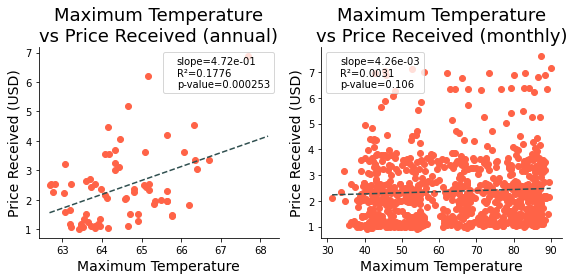

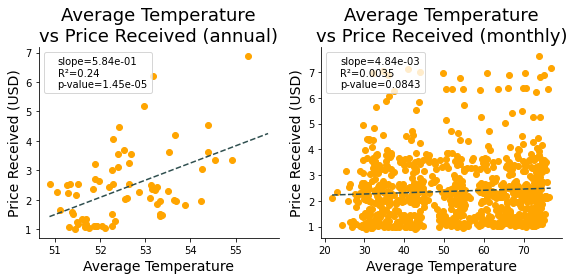

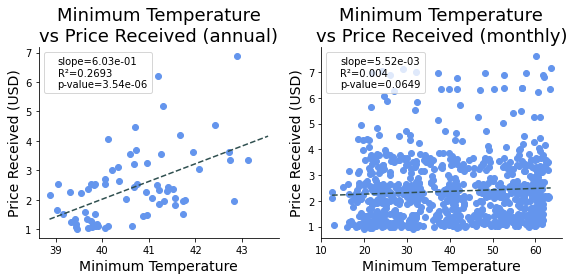

In [35]:
vs_target('Maximum Temperature', color='Tomato')
vs_target('Average Temperature', color='orange')
vs_target('Minimum Temperature', color='cornflowerblue')

Interestingly, for all three temperature features, the p-values are bellow $ \alpha $ for the annual data but above $ \alpha $ for the monthly data. Indeed, the monthly best fit lines all have very shallow slopes and low R<sup>2</sup> values (<0.01), whereas the annual data all have noticeably positive slopes and R<sup>2</sup> values greater than 0.15. These aren't the strongest predictors for the target. For the annual data, I can reject the null hypothesis, but for the monthly data I have to fail to reject the null hypothesis.  

Climate features apparently play a smaller role in predicting corn sales prices than I expected. This could be because the metric is price per bushel and not price per corn cob. Perhaps if the corn cobs are smaller, more cobs fit into the same bushel, so the price is not significantly affected. Either way, this is a surprising result I was not expecting.  

I can now look at some of the market variables and their impact on the sales price of corn. I will start with GDP and percent change in GDP (GDP_PCH).

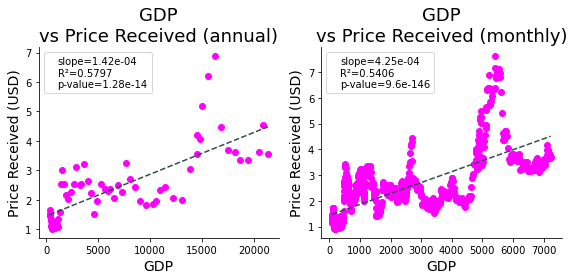

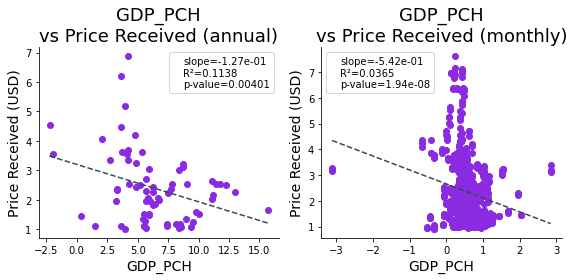

In [36]:
vs_target('GDP', color='Fuchsia')
vs_target('GDP_PCH', color='BlueViolet')

For both the annual and monthly data, there is a positive correlation between GDP and the target. The R<sup>2</sup> values for these data are both above 0.05, meaning the best fit lines are accounting for more than 50% of the variability in the plots. The p-values for the GDP data are both well bellow $ \alpha $, so I can reject the null hypothesis for these data and they are added to the respective keeper lists.  

Interestingly, for the percent change in GDP, there is a negative correlation with the target. Both plots show a negative slope for the best fit lines. These data also have low R<sup>2</sup> values (0.11 and 0.03, respectively). However, their p-values are both well bellow $ \alpha $. Therefore, I will reject the null hypothesis for these data as well.  

I will now look at the inflation rate year-over-year and month-over-month.

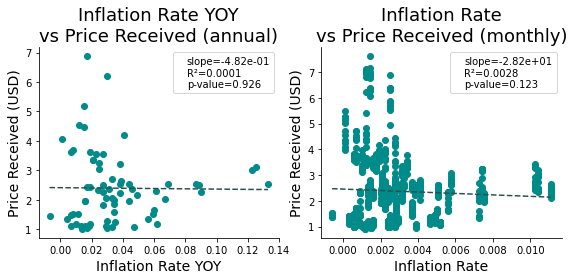

In [37]:
vs_target('Inflation Rate YOY', 'Inflation Rate', color='DarkCyan')

Both of these plots have very shallow slopes and p-values well above $ \alpha $ (0.9 and 0.1, respectively). Therefore, I fail to reject the null hypothesis for these data. They will not be included for modeling. This is somewhat of a curious result, since inflation should affect the price received. However comparing these features in this way may not be appropriate since price is shown to go up over time, and any inflation rate could happen at any time. 

Next, I will look at the US population vs the target.

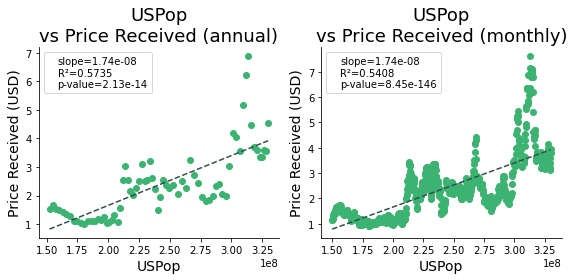

In [38]:
vs_target('USPop', color='MediumSeaGreen')

A similar relationship is seen for the US population as was seen for GDP: a positive slope and R<sup>2</sup> values just above 0.5, meaning that more than 50% of the variability is captured by the best fit lines. the p-values are well bellow $ \alpha $, so the null hypothesis is rejected for both sets of data. This relationship may be coincidental, however, as the population is growing at the same time as GDP is growing and as inflation is occurring. Therefore, population should directly relate to total bushels produced, but I am not supper confident in the relationship derived from these plots.

I will compare the target feature to the baseline prediction, which is simply the price received in the previous year or month. 

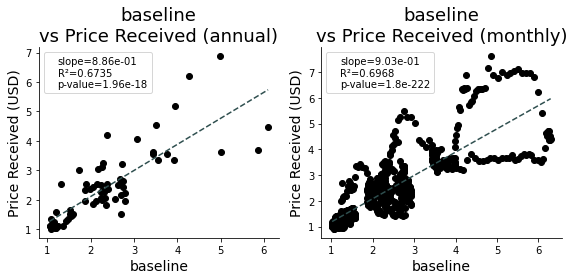

In [39]:
vs_target('baseline', color='black')

The baseline is a strong predictor of the target. The slopes for both plots are very close to 1, and the R<sip>2</sup> values are both very high, especially for the monthly data, where an R<sup>2</sup> value of 0.99 is obtained. This is not terribly surprising result. Commodity prices tend to depend on the previous price of the same commodity. Still, this will set a high bar for my predictive models. Fortunately, I can keep the baseline as a feature for my models. This is because you generally have at least some information about the current price of a commodity while trying to predict the future price of the same commodity.  

The last feature I will compare to the target is the datetime index of both datasets. This is included because price clearly has some relationship with time, likely a similar relationship as price has with population and GDP. The function I built can't take the index as an argument. So, I will have to do the coding here manually. 

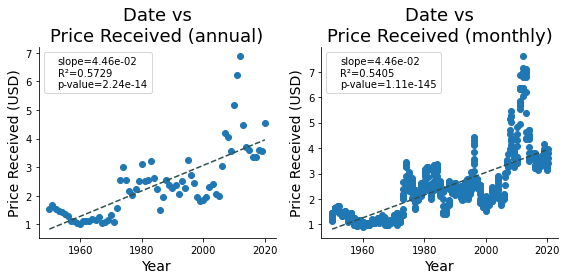

In [40]:
plt.subplots(2, figsize=(8,4))

plt.subplot(1,2,1)
            
plt.title('Date vs\nPrice Received (annual)', size=18)
plt.xlabel('Year', size=14)
plt.ylabel('Price Received (USD)', size=14)
            
slope, intercept, r_value, p_value, std_err = linregress(annual_df.index, 
    annual_df['PRICE RECEIVED, MEASURED IN $ / BU'])

plt.plot(annual_df.index, slope*annual_df.index + intercept, color='DarkSlateGray', ls='--')

plt.scatter(annual_df.index, annual_df['PRICE RECEIVED, MEASURED IN $ / BU'], 
    label=f"slope={slope:.2e}\nR\u00b2={round(r_value**2,4)}\np-value={p_value:.3n}")

plt.legend(markerscale=0, handletextpad=-1)


plt.subplot(1,2,2)
            
plt.title('Date vs\nPrice Received (monthly)', size=18)
plt.xlabel('Year', size=14)
plt.ylabel('Price Received (USD)', size=14)

X = monthly_df.index.strftime("%Y%m").astype('int') / 1E2

slope, intercept, r_value, p_value, std_err = linregress(X, monthly_df['PRICE RECEIVED, MEASURED IN $ / BU'])

plt.plot(X, slope*X + intercept, color='DarkSlateGray', ls='--')

plt.scatter(X, monthly_df['PRICE RECEIVED, MEASURED IN $ / BU'],
    label=f"slope={slope:.2e}\nR\u00b2={round(r_value**2,4)}\np-value={p_value:.3n}")

plt.legend(markerscale=0, handletextpad=-1)

plt.tight_layout()
sns.despine()
plt.show()

These plots are very similar to the US population plots. The R<sup>2</sup> values are almost exactly the same. For both annual plots the R<sup>2</sup> value is 0.57, and for the monthly plots, it's 0.54. Additionally, the p-values for these data are very far bellow $ \alpha $, meaning that these data should be kept as features in the final model.  

I will now make new dataframes that only include the features I want. I will then check the features for multicolinearity, likely removing some of the features, and then export the final dataframes for modeling.

In [41]:
# Create the new dataframes from the keepers list.
annual_keeper_df = annual_df[annual_keepers]
monthly_keeper_df = monthly_df[monthly_keepers]

# Check that the dataframes were created successfully.
display(annual_keeper_df, monthly_keeper_df)

ACRES HARVESTED  YIELD, MEASURED IN BU / ACRE  \
Year                                                  
1950       72398000.0                          38.2   
1951       71191000.0                          36.9   
1952       71353000.0                          41.8   
1953       70738000.0                          40.7   
1954       68668000.0                          39.4   
...               ...                           ...   
2016       86748000.0                         174.6   
2017       83735781.0                         176.6   
2018       81276000.0                         176.4   
2019       81337000.0                         167.5   
2020       82313000.0                         171.4   

      PRODUCTION, MEASURED IN BU  PRODUCTION, MEASURED IN $  \
Year                                                          
1950                2.764071e+09               4.222366e+09   
1951                2.628937e+09               4.364659e+09   
1952                2.980793e+09               4.557031e+09   
1953                2.881801e+09               4.291366e+09   
1954                2.707913e+09               3.872433e+09   
...                          ...                        ...   
2016                1.514804e+10               5.130430e+10   
2017                1.469141e+10               4.956785e+10   
2018                1.434037e+10               5.210240e+10   
2019                1.361993e+10               4.894062e+10   
2020                1.411145e+10               6.103900e+10   

      Cooling Degree Days  Heating Degree Days  Maximum Temperature  \
Year                                                                  
1950                 1080                 4712                63.61   
1951                 1168                 4744                63.19   
1952                 1272                 4587                64.70   
1953                 1276                 4277                65.76   
1954                 1275                 4425                65.78   
...                   ...                  ...                  ...   
2016                 1528                 3921                66.69   
2017                 1390                 3876                66.35   
2018                 1547                 4340                65.09   
2019                 1455                 4374                64.08   
2020                 1474                 3965                66.33   

      Average Temperature  Minimum Temperature          GDP   GDP_PCH  \
Year                                                                    
1950                51.39                39.17    299.82725  10.03834   
1951                51.12                39.04    346.91325  15.70438   
1952                52.27                39.85    367.34075   5.88836   
1953                53.37                40.96    389.21750   5.95544   
1954                53.33                40.87    390.54900   0.34210   
...                   ...                  ...          ...       ...   
2016                54.92                43.13  18695.10575   2.68638   
2017                54.55                42.74  19479.62250   4.19638   
2018                53.52                41.94  20527.15875   5.37760   
2019                52.68                41.27  21372.58225   4.11856   
2020                54.38                42.41  20893.74550  -2.24043   

          USPop  baseline  
Year                       
1950  152270000  1.520000  
1951  154880000  1.520000  
1952  157550000  1.590000  
1953  160180000  1.566667  
1954  163030000  1.553333  
...         ...       ...  
2016  322940000  3.923333  
2017  324990000  3.556667  
2018  326690000  3.443333  
2019  328240000  3.443333  
2020  329880000  3.510000  

[71 rows x 13 columns]

Cooling Degree Days  Precipitation          GDP   GDP_PCH  \
1950-01-01                   23           3.36    91.486000  1.256463   
1950-02-01                   11           2.23    92.547667  1.256463   
1950-03-01                   12           2.49    93.609333  1.256463   
1950-04-01                   21           2.08    94.671000  1.134147   
1950-05-01                  106           2.88    95.732667  1.134147   
...                         ...            ...          ...       ...   
2020-08-01                  351           2.43  6861.621333  2.842827   
2020-09-01                  174           2.44  7046.191333  2.842827   
2020-10-01                   77           2.18  7083.860556  0.534603   
2020-11-01                   28           1.94  7121.529778  0.534603   
2020-12-01                    5           2.06  7159.199000  0.534603   

                   USPop  baseline  
1950-01-01  1.498775e+08  1.150000  
1950-02-01  1.500950e+08  1.150000  
1950-03-01  1.503125e+08  1.150000  
1950-04-01  1.505300e+08  1.150000  
1950-05-01  1.507475e+08  1.155000  
...                  ...       ...  
2020-08-01  3.293333e+08  3.541667  
2020-09-01  3.294700e+08  3.534167  
2020-10-01  3.296067e+08  3.526389  
2020-11-01  3.297433e+08  3.522222  
2020-12-01  3.298800e+08  3.526111  

[852 rows x 6 columns]

The dataframes look good, but they are missing the target feature. I should probably also add the date as an integer to these dataframes, since there was a high correlation between date and corn price.

In [42]:
# Add target feature to the dataframes.
annual_keeper_df['PRICE RECEIVED, MEASURED IN $ / BU'] = annual_df['PRICE RECEIVED, MEASURED IN $ / BU']
monthly_keeper_df['PRICE RECEIVED, MEASURED IN $ / BU'] = monthly_df['PRICE RECEIVED, MEASURED IN $ / BU']

# Add dates as integer features.
annual_keeper_df['Year'] = annual_keeper_df.index
monthly_keeper_df['date_int'] = monthly_keeper_df.index.strftime("%Y%m").astype('int')

# Check that the dataframes were modified correctly.
display(annual_keeper_df, monthly_keeper_df)

ACRES HARVESTED  YIELD, MEASURED IN BU / ACRE  \
Year                                                  
1950       72398000.0                          38.2   
1951       71191000.0                          36.9   
1952       71353000.0                          41.8   
1953       70738000.0                          40.7   
1954       68668000.0                          39.4   
...               ...                           ...   
2016       86748000.0                         174.6   
2017       83735781.0                         176.6   
2018       81276000.0                         176.4   
2019       81337000.0                         167.5   
2020       82313000.0                         171.4   

      PRODUCTION, MEASURED IN BU  PRODUCTION, MEASURED IN $  \
Year                                                          
1950                2.764071e+09               4.222366e+09   
1951                2.628937e+09               4.364659e+09   
1952                2.980793e+09               4.557031e+09   
1953                2.881801e+09               4.291366e+09   
1954                2.707913e+09               3.872433e+09   
...                          ...                        ...   
2016                1.514804e+10               5.130430e+10   
2017                1.469141e+10               4.956785e+10   
2018                1.434037e+10               5.210240e+10   
2019                1.361993e+10               4.894062e+10   
2020                1.411145e+10               6.103900e+10   

      Cooling Degree Days  Heating Degree Days  Maximum Temperature  \
Year                                                                  
1950                 1080                 4712                63.61   
1951                 1168                 4744                63.19   
1952                 1272                 4587                64.70   
1953                 1276                 4277                65.76   
1954                 1275                 4425                65.78   
...                   ...                  ...                  ...   
2016                 1528                 3921                66.69   
2017                 1390                 3876                66.35   
2018                 1547                 4340                65.09   
2019                 1455                 4374                64.08   
2020                 1474                 3965                66.33   

      Average Temperature  Minimum Temperature          GDP   GDP_PCH  \
Year                                                                    
1950                51.39                39.17    299.82725  10.03834   
1951                51.12                39.04    346.91325  15.70438   
1952                52.27                39.85    367.34075   5.88836   
1953                53.37                40.96    389.21750   5.95544   
1954                53.33                40.87    390.54900   0.34210   
...                   ...                  ...          ...       ...   
2016                54.92                43.13  18695.10575   2.68638   
2017                54.55                42.74  19479.62250   4.19638   
2018                53.52                41.94  20527.15875   5.37760   
2019                52.68                41.27  21372.58225   4.11856   
2020                54.38                42.41  20893.74550  -2.24043   

          USPop  baseline  PRICE RECEIVED, MEASURED IN $ / BU  Year  
Year                                                                 
1950  152270000  1.520000                                1.52  1950  
1951  154880000  1.520000                                1.66  1951  
1952  157550000  1.590000                                1.52  1952  
1953  160180000  1.566667                                1.48  1953  
1954  163030000  1.553333                                1.43  1954  
...         ...       ...                                 ...   ...  
2016  322940000  3.923333           

Cooling Degree Days  Precipitation          GDP   GDP_PCH  \
1950-01-01                   23           3.36    91.486000  1.256463   
1950-02-01                   11           2.23    92.547667  1.256463   
1950-03-01                   12           2.49    93.609333  1.256463   
1950-04-01                   21           2.08    94.671000  1.134147   
1950-05-01                  106           2.88    95.732667  1.134147   
...                         ...            ...          ...       ...   
2020-08-01                  351           2.43  6861.621333  2.842827   
2020-09-01                  174           2.44  7046.191333  2.842827   
2020-10-01                   77           2.18  7083.860556  0.534603   
2020-11-01                   28           1.94  7121.529778  0.534603   
2020-12-01                    5           2.06  7159.199000  0.534603   

                   USPop  baseline  PRICE RECEIVED, MEASURED IN $ / BU  \
1950-01-01  1.498775e+08  1.150000                                1.15   
1950-02-01  1.500950e+08  1.150000                                1.16   
1950-03-01  1.503125e+08  1.150000                                1.19   
1950-04-01  1.505300e+08  1.150000                                1.26   
1950-05-01  1.507475e+08  1.155000                                1.34   
...                  ...       ...                                 ...   
2020-08-01  3.293333e+08  3.541667                                3.12   
2020-09-01  3.294700e+08  3.534167                                3.41   
2020-10-01  3.296067e+08  3.526389                                3.61   
2020-11-01  3.297433e+08  3.522222                                3.79   
2020-12-01  3.298800e+08  3.526111                                3.97   

            date_int  
1950-01-01    195001  
1950-02-01    195002  
1950-03-01    195003  
1950-04-01    195004  
1950-05-01    195005  
...              ...  
2020-08-01    202008  
2020-09-01    202009  
2020-10-01    202010  
2020-11-01    202011  
2020-12-01    202012  

[852 rows x 8 columns]

Excellent! All of the new columns have been added. The dataframes look good. I will now check all of the features against each other to check for multicolinearity.

## Checks for multicolinearity

In this section I will be checking the features for multicolinearity. I will do this by plotting a correlation heatmap of the different features. My cutoff here will be a correlation of greater than or equal to 0.7 or less than pr equal to -0.7. If I have features with those levels of correlation, I will have to drop one of them. Since the monthly dataframe has fewer features, I will check that dataframe first.

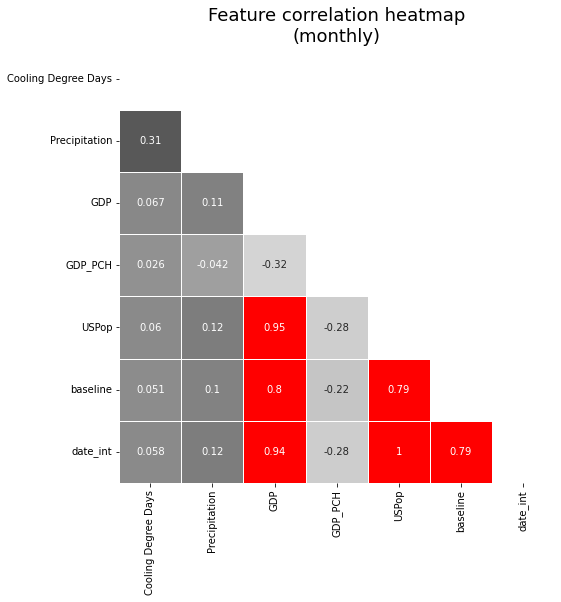

In [43]:
# Create a correlation matrix.
monthly_corr = monthly_keeper_df.drop(
    columns=['PRICE RECEIVED, MEASURED IN $ / BU']
).corr()

# Create a plot object.
plt.figure(figsize=(9,8))

# Define the colormap with instructions on what to do if a value exceeds the minimum and maximum values.
my_cmap = copy(plt.cm.Greys)
my_cmap.set_over("red")
my_cmap.set_under("orange")

# Generate the heatmap.
sns.heatmap(monthly_corr, mask=np.triu(monthly_corr), cmap=my_cmap, annot=True, vmin=-0.7, vmax=0.7, 
            square=True, linewidths=.5, cbar=False)

# Add a title.
plt.title("Feature correlation heatmap\n(monthly)", size=18)

# Show the plot.
plt.show()

There are six pairs of features exhibiting multicolinearity:
- `GDP` + `USPop`: correlation = 0.95
- `GDP` + `baseline`: correlation = 0.8
- `GDP` + `date_int`: correlation = 0.94
- `date_int` + `USPop`: correlation = 1
- `date_int` + `baseline`: correlation = 0.79 
- `baseline` + `USPop`: correlation = 0.79

`date_int` is included in 3 of these pairings and is essentially synonymous with `USPop`. Therefore, I can remove this feature.
`GDP` is also in 3 of the pairings, including one of the `date_int` pairs. `GDP` is also very similar in information content to `USPop`. Therefore, I will drop `GDP` as well.

In [44]:
# Drop the columns.
monthly_keeper_df.drop(columns=['date_int', 'GDP'], inplace=True)

# Check that the columns dropped successfully.
display(monthly_keeper_df)

Cooling Degree Days  Precipitation   GDP_PCH         USPop  \
1950-01-01                   23           3.36  1.256463  1.498775e+08   
1950-02-01                   11           2.23  1.256463  1.500950e+08   
1950-03-01                   12           2.49  1.256463  1.503125e+08   
1950-04-01                   21           2.08  1.134147  1.505300e+08   
1950-05-01                  106           2.88  1.134147  1.507475e+08   
...                         ...            ...       ...           ...   
2020-08-01                  351           2.43  2.842827  3.293333e+08   
2020-09-01                  174           2.44  2.842827  3.294700e+08   
2020-10-01                   77           2.18  0.534603  3.296067e+08   
2020-11-01                   28           1.94  0.534603  3.297433e+08   
2020-12-01                    5           2.06  0.534603  3.298800e+08   

            baseline  PRICE RECEIVED, MEASURED IN $ / BU  
1950-01-01  1.150000                                1.15  
1950-02-01  1.150000                                1.16  
1950-03-01  1.150000                                1.19  
1950-04-01  1.150000                                1.26  
1950-05-01  1.155000                                1.34  
...              ...                                 ...  
2020-08-01  3.541667                                3.12  
2020-09-01  3.534167                                3.41  
2020-10-01  3.526389                                3.61  
2020-11-01  3.522222                                3.79  
2020-12-01  3.526111                                3.97  

[852 rows x 6 columns]

The columns were dropped successfully. I will now take one last look at the correlation matrix before exporting the data.

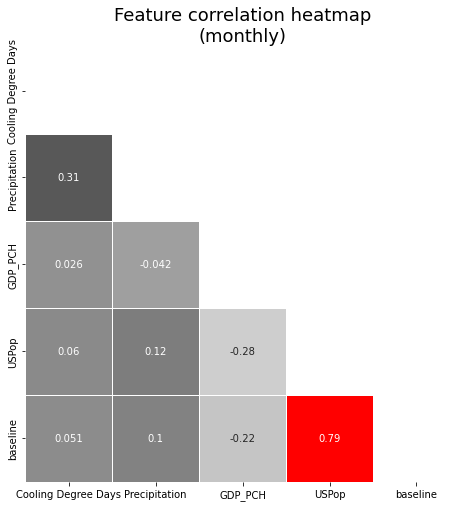

In [45]:
# Create a correlation matrix.
monthly_corr = monthly_keeper_df.drop(
    columns=['PRICE RECEIVED, MEASURED IN $ / BU']
).corr()

# Create a plot object.
plt.figure(figsize=(9,8))

# Define the colormap with instructions on what to do if a value exceeds the minimum and maximum values.
my_cmap = copy(plt.cm.Greys)
my_cmap.set_over("red")
my_cmap.set_under("orange")

# Generate the heatmap.
sns.heatmap(monthly_corr, mask=np.triu(monthly_corr), cmap=my_cmap, annot=True, vmin=-0.7, vmax=0.7, 
            square=True, linewidths=.5, cbar=False)

# Add a title.
plt.title("Feature correlation heatmap\n(monthly)", size=18)

# Show the plot.
plt.show()

There is still a high correlation between the `baseline` and `USPop` features. However, these both seem like important features to me. Including a pair of features like this in my models may cause some issues, but in this case I think it is worth the risk. I am including 5 features for modeling:
- `Cooling Degree Days`
- `Precipitation`
- `GDP_PCH`
- `USPop`
- `baseline`

I will now export the data for modeling.

In [46]:
monthly_keeper_df.to_csv('./DataFrames/monthly_df_model_ready.csv')

I can now look at multicolinearity for the annual data. Just like with the monthly data, I will start by generating a correlation heat map.

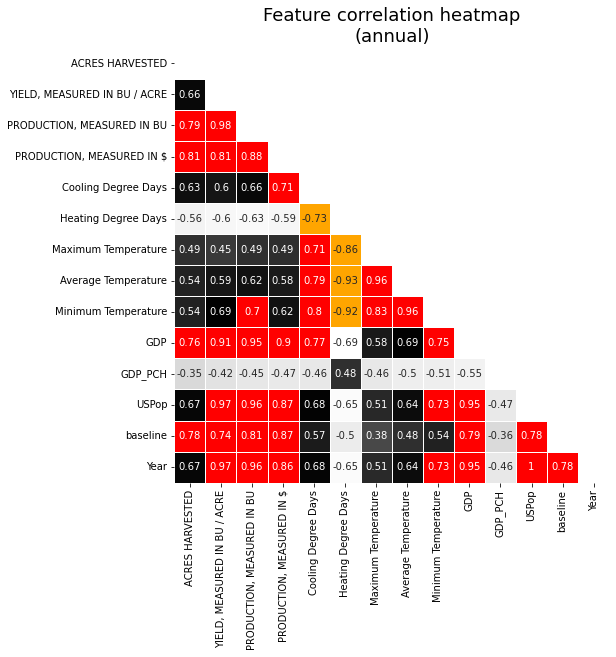

In [47]:
annual_corr = annual_keeper_df.drop(
    columns=['PRICE RECEIVED, MEASURED IN $ / BU']
).corr()

plt.figure(figsize=(15,8))

my_cmap = copy(plt.cm.Greys)
my_cmap.set_over("red")
my_cmap.set_under("orange")

sns.heatmap(annual_corr, mask=np.triu(annual_corr), cmap=my_cmap, annot=True, vmin=-0.7, vmax=0.7, 
            square=True, linewidths=.5, cbar=False)

plt.title("Feature correlation heatmap\n(annual)", size=18)

plt.show()

Wow! There is a lot of multicolinearity here. Red squares correspond to being above 0.7 and teal squares are bellow -0.7. Because there are so many pairs, I want list all of them as I did for the monthly data. Instead, I can talk about some general offenders to eliminate to reduce the size of the correlation matrix. 
- All of the temperature data (`Maximum Temperature`, `Minimum Temperature`, `Average Temperature`, `Heating Degree Days`, and `Cooling Degree Days`) are colinear with one another. The `Cooling Degree Days` feature has the highest R<sup>2</sup> value for predicting the target. Therefore, I will drop the other temperature features.
- `Year` as mentioned before is fairly close to GDP, so `Year` can be dropped.
- `ACRES HARVESTED` has not changed much over the last 70 years. It can be dropped.

I will start with dropping these features and then look at the resulting correlation heat map.

In [48]:
# Drop columns.
annual_keeper_df.drop(columns=[
    'Maximum Temperature', 
    'Minimum Temperature', 
    'Average Temperature', 
    'Heating Degree Days',
    'Year',
    'ACRES HARVESTED',
], inplace=True
)

# Check the updated dataframe.
display(annual_keeper_df)

YIELD, MEASURED IN BU / ACRE  PRODUCTION, MEASURED IN BU  \
Year                                                             
1950                          38.2                2.764071e+09   
1951                          36.9                2.628937e+09   
1952                          41.8                2.980793e+09   
1953                          40.7                2.881801e+09   
1954                          39.4                2.707913e+09   
...                            ...                         ...   
2016                         174.6                1.514804e+10   
2017                         176.6                1.469141e+10   
2018                         176.4                1.434037e+10   
2019                         167.5                1.361993e+10   
2020                         171.4                1.411145e+10   

      PRODUCTION, MEASURED IN $  Cooling Degree Days          GDP   GDP_PCH  \
Year                                                                          
1950               4.222366e+09                 1080    299.82725  10.03834   
1951               4.364659e+09                 1168    346.91325  15.70438   
1952               4.557031e+09                 1272    367.34075   5.88836   
1953               4.291366e+09                 1276    389.21750   5.95544   
1954               3.872433e+09                 1275    390.54900   0.34210   
...                         ...                  ...          ...       ...   
2016               5.130430e+10                 1528  18695.10575   2.68638   
2017               4.956785e+10                 1390  19479.62250   4.19638   
2018               5.210240e+10                 1547  20527.15875   5.37760   
2019               4.894062e+10                 1455  21372.58225   4.11856   
2020               6.103900e+10                 1474  20893.74550  -2.24043   

          USPop  baseline  PRICE RECEIVED, MEASURED IN $ / BU  
Year                                                           
1950  152270000  1.520000                                1.52  
1951  154880000  1.520000                                1.66  
1952  157550000  1.590000                                1.52  
1953  160180000  1.566667                                1.48  
1954  163030000  1.553333                                1.43  
...         ...       ...                                 ...  
2016  322940000  3.923333                                3.36  
2017  324990000  3.556667                                3.36  
2018  326690000  3.443333                                3.61  
2019  328240000  3.443333                                3.56  
2020  329880000  3.510000                                4.53  

[71 rows x 9 columns]

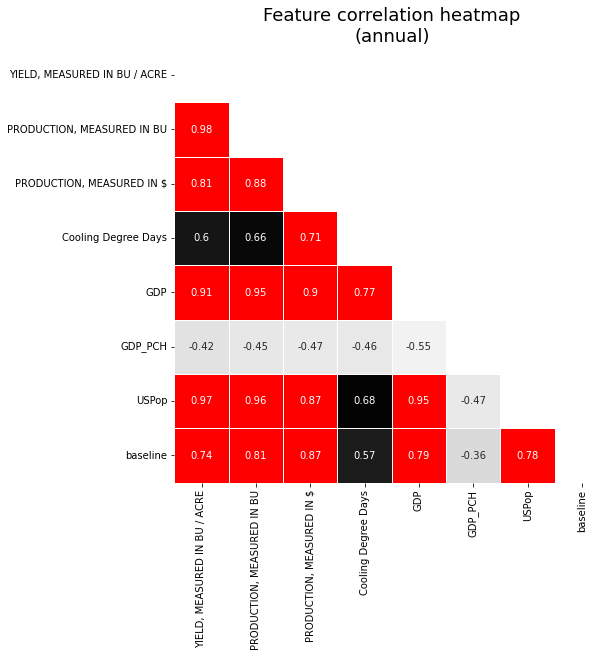

In [49]:
annual_corr = annual_keeper_df.drop(
    columns=['PRICE RECEIVED, MEASURED IN $ / BU']
).corr()

plt.figure(figsize=(15,8))

my_cmap = copy(plt.cm.Greys)
my_cmap.set_over("red")
my_cmap.set_under("orange")

sns.heatmap(annual_corr, mask=np.triu(annual_corr), cmap=my_cmap, annot=True, vmin=-0.7, vmax=0.7, 
            square=True, linewidths=.5, cbar=False)

plt.title("Feature correlation heatmap\n(annual)", size=18)

plt.show()

- All of the data downloaded from the USDA data repository (`YIELD, MEASURED IN BU / ACRE`, `PRODUCTION, MEASURED IN BU`, and `PRODUCTION, MEASURED IN $`) are colinear with one another. `PRODUCTION, MEASURED IN $` Has the highest R<sup>2</sup> value of any of these features, so I will remove the other ones.
- `GDP` is paired with 6 other features. I will drop this feature as well.

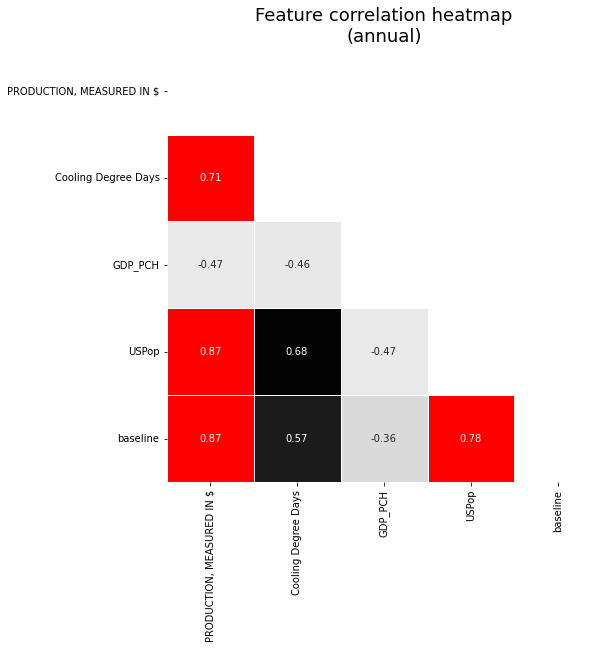

In [50]:
annual_keeper_df.drop(columns=[
    'YIELD, MEASURED IN BU / ACRE',
    'PRODUCTION, MEASURED IN BU',
    'GDP'
], inplace=True)

annual_corr = annual_keeper_df.drop(
    columns=['PRICE RECEIVED, MEASURED IN $ / BU']
).corr()

plt.figure(figsize=(15,8))

my_cmap = copy(plt.cm.Greys)
my_cmap.set_over("red")
my_cmap.set_under("orange")

sns.heatmap(annual_corr, mask=np.triu(annual_corr), cmap=my_cmap, annot=True, vmin=-0.7, vmax=0.7, 
            square=True, linewidths=.5, cbar=False)

plt.title("Feature correlation heatmap\n(annual)", size=18)

plt.show()

By this point, most of the colinearity has been removed. However, `PRODUCTION, MEASURED IN $` is still colinear with 3 other features. The `USPop` and `baseline` are also again colinear with one another, but they will both be retained for the final model. I will now drop the necessary column, double check the dataframe, and then export it for modeling.

In [51]:
# Drop the column.
annual_keeper_df.drop(columns='PRODUCTION, MEASURED IN $', inplace=True)

# Check to see if the drop worked correclty.
display(annual_keeper_df)

Cooling Degree Days   GDP_PCH      USPop  baseline  \
Year                                                       
1950                 1080  10.03834  152270000  1.520000   
1951                 1168  15.70438  154880000  1.520000   
1952                 1272   5.88836  157550000  1.590000   
1953                 1276   5.95544  160180000  1.566667   
1954                 1275   0.34210  163030000  1.553333   
...                   ...       ...        ...       ...   
2016                 1528   2.68638  322940000  3.923333   
2017                 1390   4.19638  324990000  3.556667   
2018                 1547   5.37760  326690000  3.443333   
2019                 1455   4.11856  328240000  3.443333   
2020                 1474  -2.24043  329880000  3.510000   

      PRICE RECEIVED, MEASURED IN $ / BU  
Year                                      
1950                                1.52  
1951                                1.66  
1952                                1.52  
1953                                1.48  
1954                                1.43  
...                                  ...  
2016                                3.36  
2017                                3.36  
2018                                3.61  
2019                                3.56  
2020                                4.53  

[71 rows x 5 columns]

I am retaining 4 features for the annual data:
- `Cooling Degree Days`
- `GDP_PCH`
- `USPop`
- `baseline`

I will now export the data.

In [52]:
# Export the data as a csv file.
annual_keeper_df.to_csv('./Dataframes/annual_df_model_ready.csv')

## Conclusions

The data has been visualized and analyzed for their relationship to the target feature, `PRICE RECEIVED, MEASURED IN $ / BU`, for both the annual and monthly dataframes. The independent features were then screened for multicolinearity, and the resulting dataframes have been exported for use in modeling.